<img src = 'image/k-water_logo.png' alt = 'Drawing' style = 'width: 200px;'/>
<p style = 'font-size:30px; line-height:1em'>[Notebook] 막 설비 상태 모니터링을 위한 막 운영인자 예측 </p>

# 분석개요
## 분석주제 및 목표
* 빅데이터 기반 딥러닝을 통한 막설비 제어/모니터링을 위한 막 운영인자 예측   
(막 운영인자:  RO막-비플럭스(Sflux), MF막-R(막저항값))

## 분석과정
분석환경 설정 > 데이터 가져오기 > 데이터 전처리 > 모델링
* 데이터 전처리: 정상 범위를 벗어나는 데이터 NA처리 후 삭제
* 모델링: 총 3개 모델 사용(NN, LSTM, GRU)


## 데이터 설명
* kwater_recipe06_dataset1.xlsx
  - 데이터 유형: xlsx 파일
  - 파일 크기: 관측치 8760개(행), 변수 10개(열), 1.27MB
  - 데이터 수집: 아산정수장, 2021.01 ~ 2021.12, 1시간 간격 수집
  - 데이터 내용: 2021년 RO1, MF1막의 원수수질, 막 운영인자(비플럭스, R) 데이터    
** RO1 sheet, MF1 sheet로 구성

* kwater_recipe06_dataset2.xlsx
  - 데이터 유형: xlsx파일
  - 파일 크기: 관측치 4344개(행), 변수 10개(열), 701KB
  - 데이터 수집: 아산정수장, 2022.01 ~ 2022.06, 1시간 간격 수집
  - 데이터 내용: 2022년 RO1, MF1막의 원수수질, 막 운영인자(비플럭스, R)  데이터  
** RO1 sheet, MF1 sheet로 구성

## 변수 설명
총 변수 수: 10개  (RO막 예측 시 10개, MF막 예측 시  10개)
- 시간 변수: 1개 (Date)
- 종속 변수: RO막-비플럭스(Sflux), MF막-R(막저항값)
- 독립 변수: 원수 수온, 원수 탁도, 원수 TDS, 원수 전기전도도, 원수 pH  
** RO막의 비플럭스를 예측할 시와 MF막의 R값을 예측할 시에 독립변수 항목이 동일합니다.
- 분석에 쓰이지 않는 변수: 유입압력, 생산량, 운영차압  
** 분석에는 원수수질관련 변수만 사용합니다.

> (RO, MF막 선택) 이라고 되어있는 부분 **(3.1 종속변수 선택)** 은 주석을 이용해서 분석에 이용할 부분만 선택하여 분석을 진행하시면 됩니다.

# 분석환경 설정

In [1]:
# warnins 제거
options(warn = -1)

In [2]:
# 작업 디렉토리 설정
setwd(paste0('/home/', Sys.getenv('USER') ,'/recipe06'))

## 패키지 불러오기

* ggplot2: 시각화
* gridExtra: plot 배치
* scales: 데이터 조작
* MLmetrics: 평가지표
* readxl: 엑셀데이터 불러오기
* dplyr: 데이터 조작
* keras: 딥러닝(lstm, gru)
* tensorflow: 딥러닝(lstm, gru)
* data.table: 데이터 조작
* neuralnet: NN모델 

In [3]:
# 패키지 불러오기
suppressPackageStartupMessages({
    library(ggplot2) 
    library(gridExtra) 
    library(scales) 
    library(MLmetrics) 
    library(readxl) 
    library(dplyr) 
    library(keras)
    library(tensorflow) 
    library(data.table) 
    library(neuralnet)  
})

In [4]:
# 케라스 설치(1회 설치 후 주석 처리)
# 가상환경을 생성하고, 해당 가상환경에서 TensorFlow와 TensorFlow 관련 패키지들을 설치
install_keras()

Using Python: /srv/conda/envs/notebook/bin/python3.8
Creating virtual environment '~/.virtualenvs/r-reticulate' ... 


+ '/srv/conda/envs/notebook/bin/python3.8' -m venv '/home/sylee/.virtualenvs/r-reticulate'



Done!
Installing packages: 'pip', 'wheel', 'setuptools', 'numpy'


+ '/home/sylee/.virtualenvs/r-reticulate/bin/python' -m pip install --upgrade --no-user 'pip' 'wheel' 'setuptools' 'numpy'



Virtual environment '~/.virtualenvs/r-reticulate' successfully created.
Using virtual environment '~/.virtualenvs/r-reticulate' ...


+ '/home/sylee/.virtualenvs/r-reticulate/bin/python' -m pip install --upgrade --no-user --ignore-installed 'tensorflow==2.9.*' 'tensorflow-hub' 'scipy' 'requests' 'Pillow' 'h5py' 'pandas' 'pydot'




Installation complete.



## 사용자 함수 불러오기
- make_lag_data_fn: y변수를 제외한 모든 변수를 times만큼 시점을 뒤로 이동시켜 컬럼 생성
- plot_nnet_fn: neuralnet()함수에 의해 생성되는 class 'nn' 객체를 위한 시각화
- ts_graph_fn: ggplot을 이용한 시계열 그래프(line graph) 작성  
- restore_scale_fn: 변경된 스케일을 원래 스케일로 복원
- train_plot_fn: lstm, gru의 epoch별 loss, rmse확인, ann의 신경망 시각화
- result_plot_fn: 시계열 plot, 실제값, 예측값 비교 plot 생성, 저장
- evaluation_fn: 평가지표 생성 후 csv로 저장

In [5]:
# 사용자 함수 불러오기
source('src/R_function.r')

# 데이터 가져오기

## 종속변수 선택(RO, MF막 선택)

> 예측하고자 하는 막의 운영인자만 선택하여 주석을 풀고 셀을 실행해주세요. RO막은 Sflux, MF막은 R입니다.

In [6]:
# 종속변수(y값) 지정

y.var <- c('SFLUX')  # RO막
# y.var <- c('R')  # MF막

In [7]:
# 데이터 불러오기

# read_excel(경로, 엑셀시트): xlsx파일 로드
if (y.var == 'SFLUX'){  # RO막
    data1_df <- read_excel('input/kwater_recipe06_dataset1.xlsx', sheet = 'RO1')
    data2_df <- read_excel('input/kwater_recipe06_dataset2.xlsx', sheet = 'RO1')
    } else {  # MF막
    data1_df <- read_excel('input/kwater_recipe06_dataset1.xlsx', sheet = 'MF1')
    data2_df <- read_excel('input/kwater_recipe06_dataset2.xlsx', sheet = 'MF1')
}

In [8]:
# 2021, 2022년 데이터 합치기

# rbind(): 데이터를 위아래로 행 결합
# head(data, n): 데이터 1행부터 n행까지 출력
data_df <- rbind(data1_df, data2_df)
head(data_df, 10)

Date,운영차압,비플럭스,원수 수온,원수 탁도,원수 TDS,원수 전기전도도,원수 pH,유입압력,생산량
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01 00:00:01,3.36,5.899170,3.69,0.41,503.730,839.55,7.06,12.04,781.43
2021-01-01 01:00:01,3.41,5.842618,3.68,0.39,504.048,840.08,7.06,12.15,781.57
2021-01-01 02:00:01,3.38,5.827946,3.61,0.38,504.732,841.22,7.07,12.16,778.91
2021-01-01 03:00:01,3.33,5.891886,3.59,0.33,505.524,842.54,7.07,12.08,781.64
2021-01-01 04:00:01,3.58,5.898117,3.52,0.32,506.148,843.58,7.07,12.17,779.79
2021-01-01 05:00:01,3.45,5.885573,3.48,0.32,506.658,844.43,7.07,12.23,785.39
2021-01-01 06:00:01,3.40,5.853541,3.44,0.34,507.018,845.03,7.08,12.17,776.66
2021-01-01 07:00:01,3.40,5.836569,3.41,0.34,507.684,846.14,7.08,12.20,776.00
2021-01-01 08:00:01,3.41,5.839553,3.39,0.34,508.272,847.12,7.08,12.23,777.59


In [9]:
# 컬럼명 변경

# names(data): 데이터의 열이름들을 출력
if (y.var == 'SFLUX'){  # RO막
    names(data_df) <- c('DATE', 'OPER_PR', 'SFLUX', 'TEMP', 'TUR', 'TDS', 'CON', 'PH', 'INPUT_PR', 'OUTPUT')
    } else {  # MF막
    names(data_df) <- c('DATE', 'OPER_PR', 'R', 'TEMP', 'TUR', 'TDS', 'CON', 'PH', 'INPUT_PR', 'OUTPUT')
    }

# 데이터 탐색

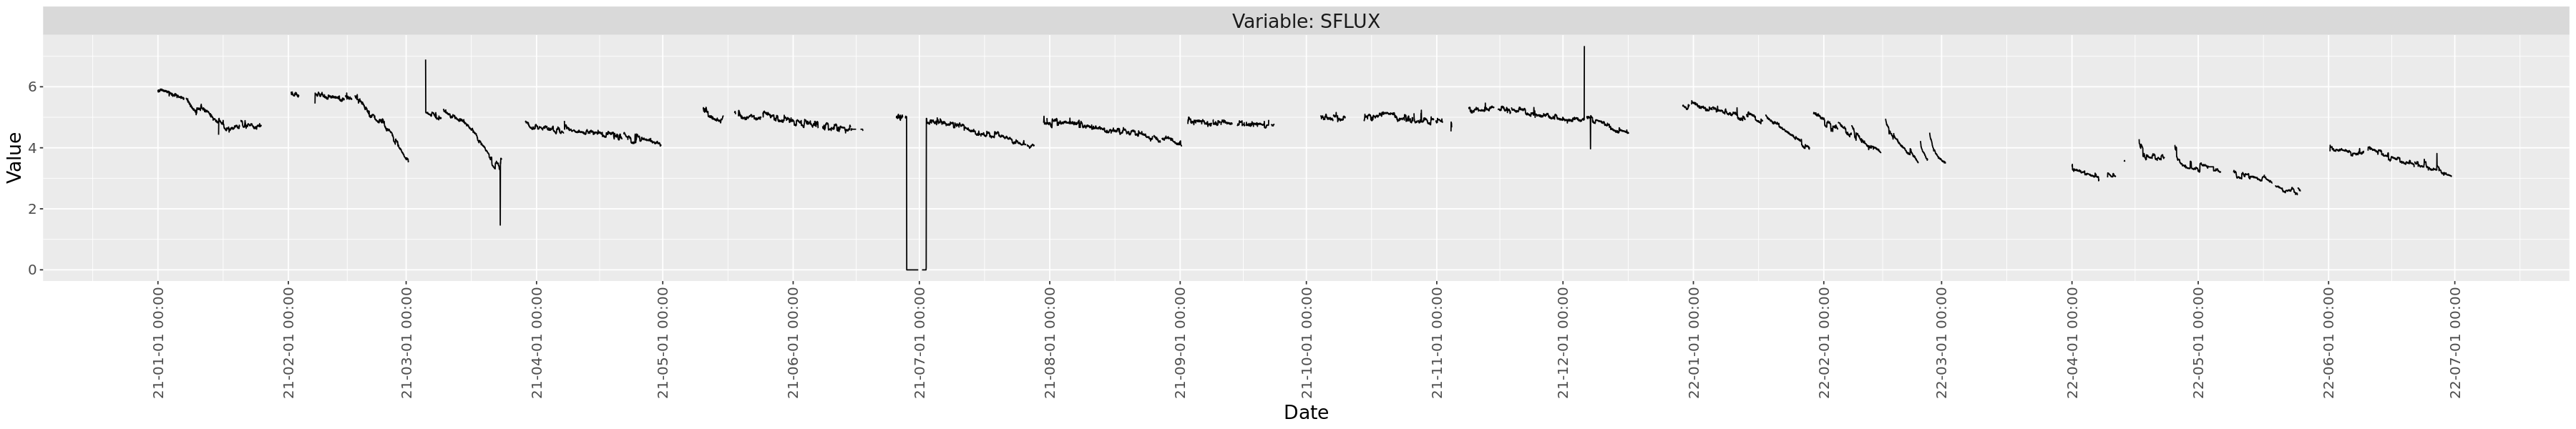

In [10]:
# 종속변수 시계열 그래프 

# ts_graph_fn(): ggplot을 이용한 시계열 그래프(line graph) 작성하는 사용자 함수
options(repr.plot.width = 30, repr.plot.height = 5)
ts_graph_fn(input_df = as.data.frame(data_df[, c(1, 3)]), input.var = 'DATE', input.scales = 'free')

(RO막) 비플럭스의 정상범위(1<SFLUX<20) 벗어나는 이상치가 보입니다. 또한 중간중간 값이 없는 부분(결측)이 보입니다. 전처리 과정에서 이상치나 결측치가 포함된 행은 NA처리 후 제거 하겠습니다.  
(MF막) R값(막 저항값)의 범위(2<R<9) 벗어나는 이상치가 보입니다. 전처리 과정에서 이상치가 포함된 행은 NA처리 후 제거 하겠습니다.  

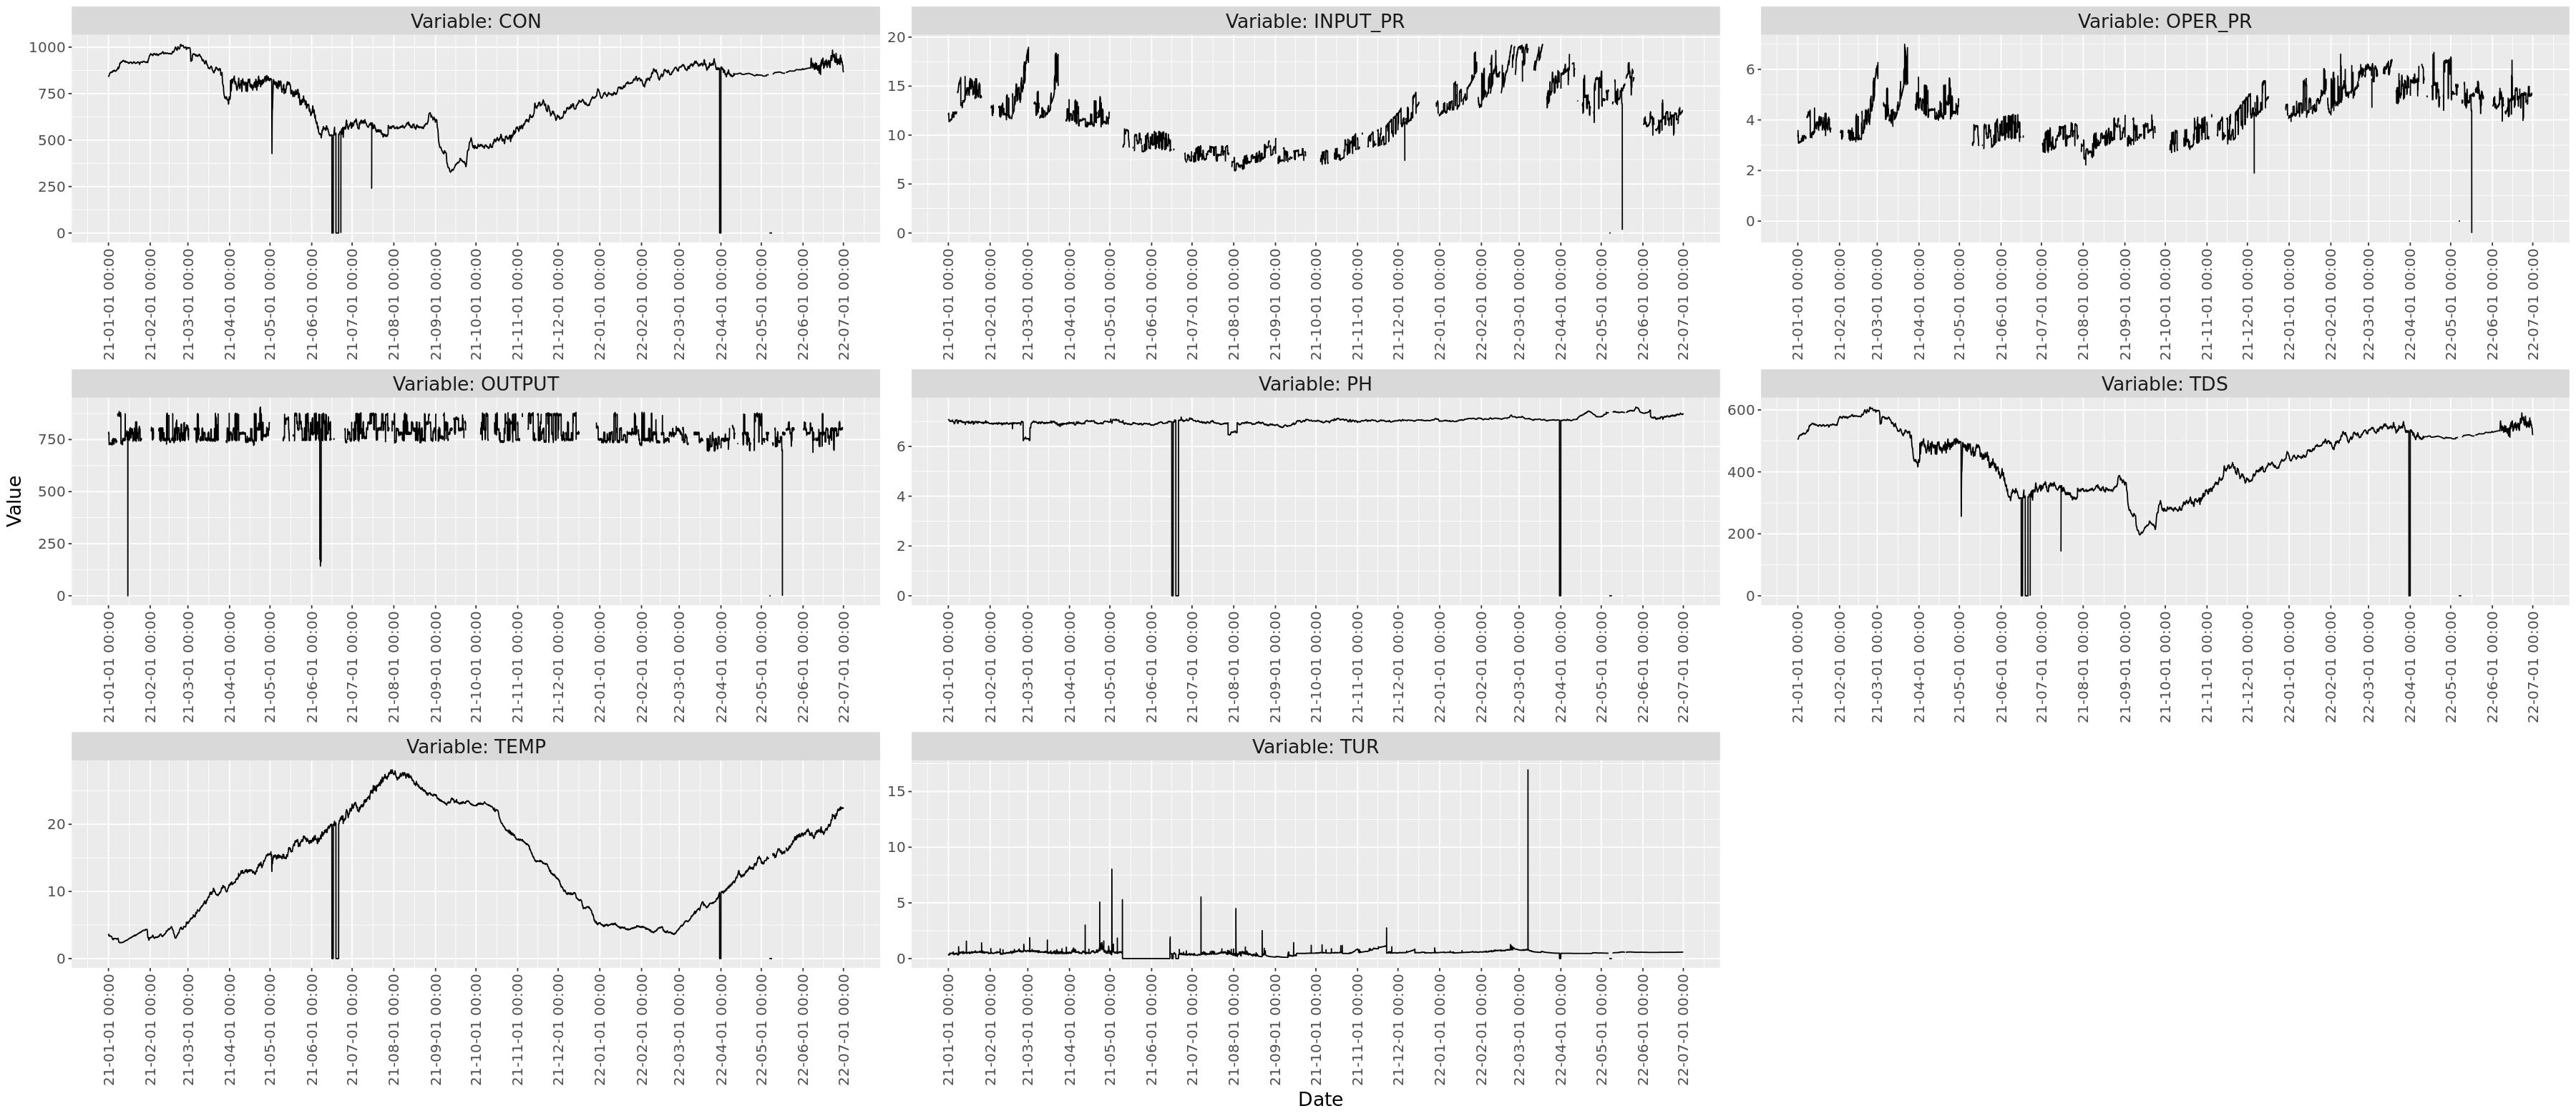

In [11]:
# 독립변수 시계열 그래프
options(repr.plot.width = 30, repr.plot.height = 13)
ts_graph_fn(input_df = as.data.frame(data_df[, -3]), input.var = 'DATE', input.scales = 'free')

(RO막) 정상범위를 벗어난 운영차압(OPER_PR)이 음수거나, 생산량(OUTPUT)이 90미만인 값이 확인됩니다. 전처리 과정에서 이 값들이 포함된 행은 제거 하겠습니다.  
(MF막) 정상범위를 벗어난 운영차압(OPER_PR)이 40미만이거나, 생산량(OUTPUT)이 90미만인 값이 확인됩니다. 전처리 과정에서 이 값들이 포함된 행은 제거 하겠습니다.

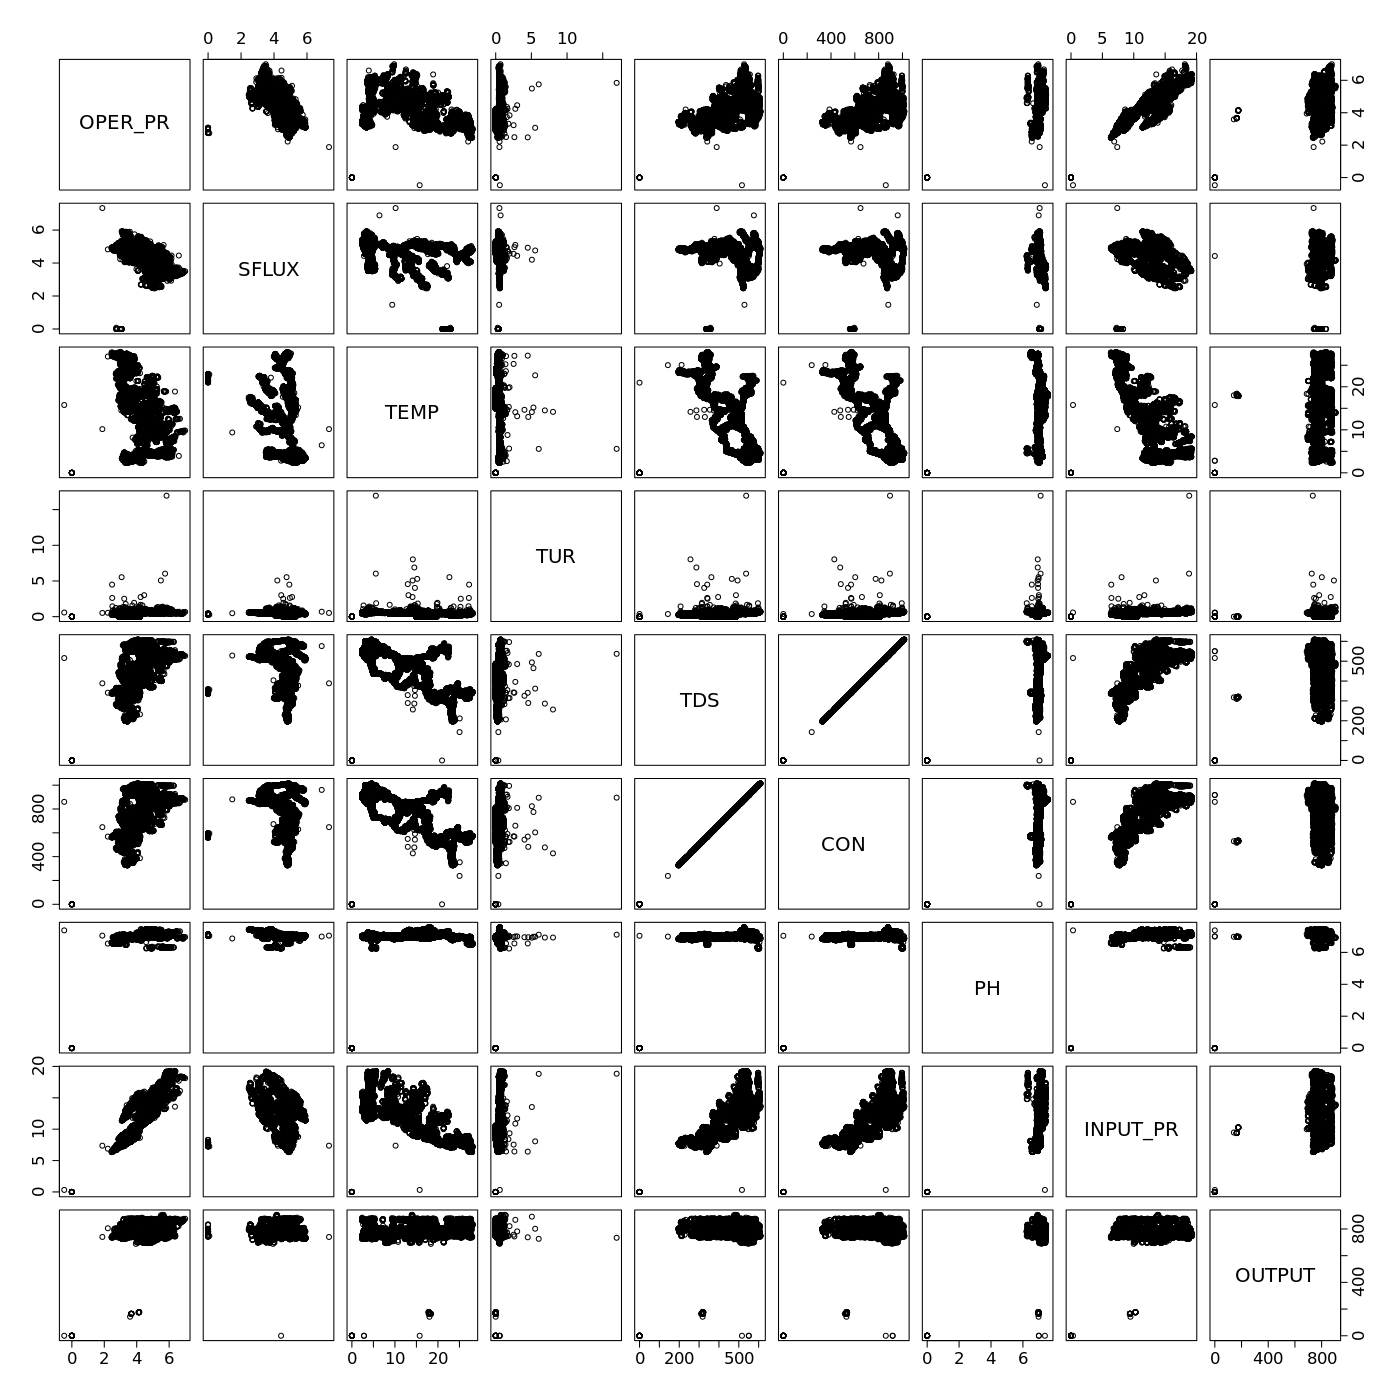

In [12]:
# 독립변수와 종속변수의 상관관계 plot
options(repr.plot.width = 14, repr.plot.height = 14, repr.plot.res = 100)
plot(data_df[, -1], cex.axis = 1.5, cex.labels = 1.8)

(RO막) 종속변수인 SFLUX와 독립변수들간에 상관관계는 plot에서 찾기 어렵습니다.  
(MF막) 종속변수인 R와 독립변수들간에 상관관계는 plot에서 찾기 어렵습니다.  
(RO막, MF막) TDS와 CON은 상관관계가 매우 강해 보여 상관계수를 확인해보겠습니다.

In [13]:
# 독립변수와 종속변수의 상관계수
cor(data_df[, -1], use = 'complete.obs')

,OPER_PR,SFLUX,TEMP,TUR,TDS,CON,PH,INPUT_PR,OUTPUT
OPER_PR,1.0000000,-0.58476554,-0.46263520,0.34939575,0.5645918,0.5645918,0.43503843,0.84770136,0.14742463
SFLUX,-0.5847655,1.00000000,-0.19257488,-0.09896307,-0.2538443,-0.2538443,-0.48969216,-0.37475806,0.01477800
TEMP,-0.4626352,-0.19257488,1.00000000,-0.35149197,-0.6968280,-0.6968280,-0.09669957,-0.78941186,0.25484929
TUR,0.3493957,-0.09896307,-0.35149197,1.00000000,0.3309636,0.3309636,0.22799114,0.39445130,-0.11129463
TDS,0.5645918,-0.25384430,-0.69682803,0.33096357,1.0000000,1.0000000,0.29112017,0.77013246,-0.27039124
CON,0.5645918,-0.25384430,-0.69682803,0.33096357,1.0000000,1.0000000,0.29112017,0.77013246,-0.27039124
PH,0.4350384,-0.48969216,-0.09669957,0.22799114,0.2911202,0.2911202,1.00000000,0.34973953,-0.12618034
INPUT_PR,0.8477014,-0.37475806,-0.78941186,0.39445130,0.7701325,0.7701325,0.34973953,1.00000000,-0.06390478
OUTPUT,0.1474246,0.01477800,0.25484929,-0.11129463,-0.2703912,-0.2703912,-0.12618034,-0.06390478,1.00000000


(RO막, MF막) TDS와 CON의 상관관계가 1입니다. 모델학습에서 두 변수가 종속변수를 예측하는 능력이 비슷하므로, 모델의 복잡성을 줄이기 위해 TDS를 제거 후 학습에 이용하겠습니다.

# 데이터 전처리

## 삭제 예정인 데이터 NA처리

화학세정, 역세척 기간의 경우 정상적인 막 운영기간이 아니므로 정상 범위를 벗어나는 데이터가 생깁니다.  
향후 모델 학습을 위한 지연(lag)된 데이터셋을 만든 후 비정상 데이터를 삭제하기 위해 NA처리하겠습니다.

**[MF막]**
 - R값(막 저항값)의 범위(2<R<9) 벗어나는 부분 삭제
 - 운영차압(OPER_PR)이 40미만일 때 삭제
 - 생산량(OUTPUT)이 90미만일 때 삭제 

**[RO막]**
 - 비플럭스의 범위(1<SFLUX<20) 벗어나는 부분 삭제 
 - 운영차압(OPER_PR)이 음수일 때 삭제 
 - 생산량(OUTPUT)이 90미만일 때 삭제

In [14]:
## 삭제할 데이터가 포함된 행을 모두 NA처리

# plot을 그리기 위해 date변수 정의 
date.var <- data_df$DATE

# 삭제하려는 데이터가 포함된 행 NA처리
# mutate_at(vars(변수), 함수): 변수에 함수를 적용 
# if_else(조건, 반환값1, 반환값2): 조건문이 참이면 반환값1을 반환, 반환값2를 반환
# apply(data, 행/열(0/1), 함수): data를 행 또는 열 방향으로 함수적용
# grep(검색어, data): data안에서 검색어가 포함된 행 인덱스 추출
if (y.var == 'SFLUX'){  # RO막
        data_df <- data_df %>%
        mutate_at(vars('OPER_PR'), ~ if_else(. < 0, NA_real_, .))%>%  # 운영차압이 음수일 때
        mutate_at(vars('SFLUX'), ~ if_else(. < 1 | . > 20, NA_real_, .))%>%  # 비플럭스의 범위(1<비플럭스<20) 벗어나는 부분 
        mutate_at(vars('OUTPUT'), ~ if_else(. < 90, NA_real_, .))  # k열(생산량)이 90미만일때

        data_df[apply(is.na(data_df), 1, any), ] <- NA  # na포함하는 행
        data_df[grep('err', apply(data_df, 1, paste0, collapse = ' ')), ] <- NA  # 'err' 포함하는 행
        data_df[grep('#DIV/0!', apply(data_df, 1, paste0, collapse = ' ')), ] <- NA
        data_df[grep('#VALUE!', apply(data_df, 1, paste0, collapse = ' ')), ] <- NA
} else {  # MF막
    data_df <- data_df %>%
    mutate_at(vars('OPER_PR'), ~ if_else(. < 40, NA_real_, .))%>%  # 운영차압이 40미만일 때
    mutate_at(vars('R'), ~ if_else(. < 2 | . > 9, NA_real_, .))%>%  # 비플럭스의 범위(2<비플럭스<9) 벗어나는 부분 
    mutate_at(vars('OUTPUT'), ~ if_else(. < 90, NA_real_, .))  # k열(생산량)이 90미만일때

    data_df[apply(is.na(data_df), 1, any), ] <- NA  # na포함하는 행
    data_df[grep('err', apply(data_df, 1, paste0, collapse = ' ')), ] <- NA  # 'err' 포함하는 행
    data_df[grep('#DIV/0!', apply(data_df, 1, paste0, collapse = ' ')), ] <- NA
    data_df[grep('#VALUE!', apply(data_df, 1, paste0, collapse = ' ')), ] <- NA
    }

# NA로 된 date변수 복원
data_df$DATE <- date.var

## 데이터 전처리 후 확인

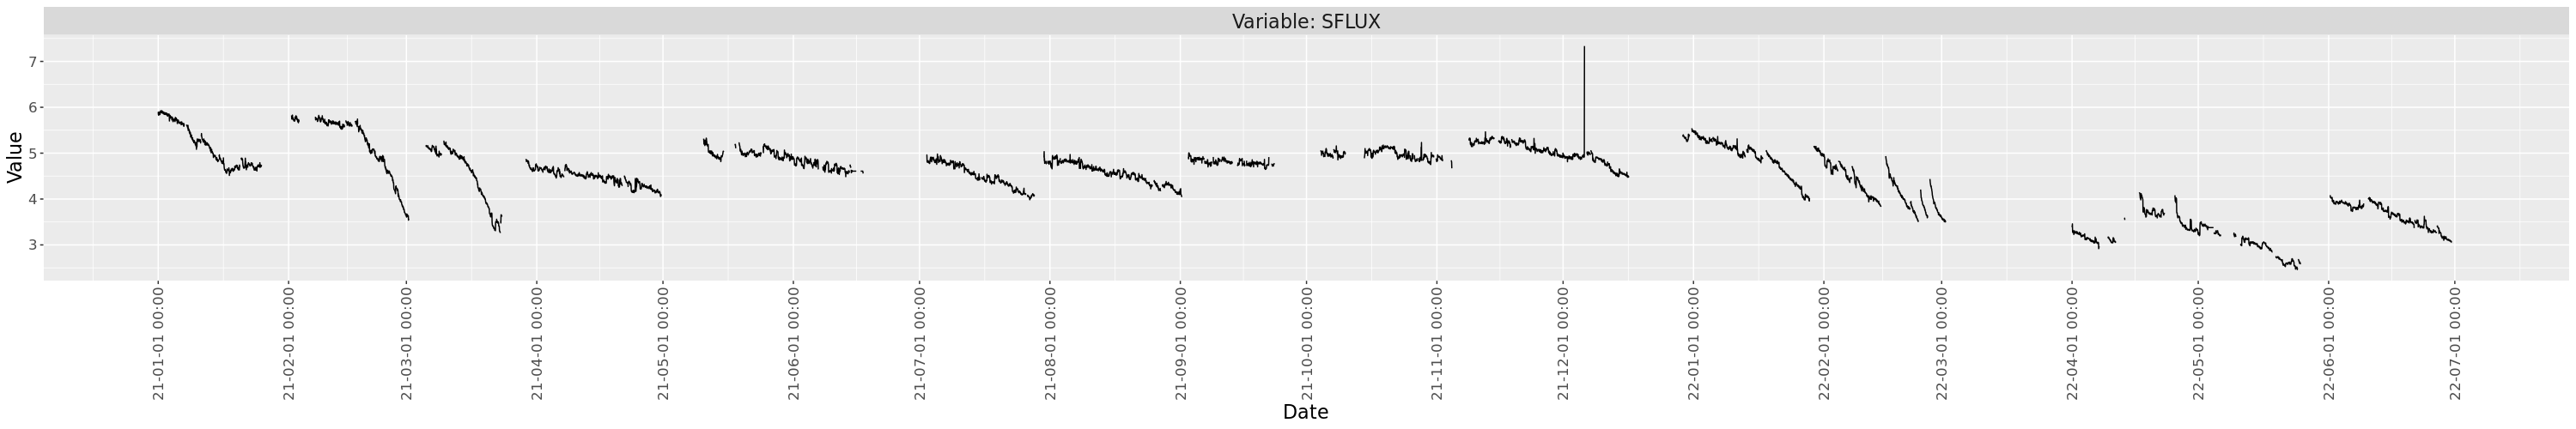

In [15]:
# 종속변수 시계열 그래프 
# ts_graph_fn(): ggplot을 이용한 시계열 그래프(line graph) 작성하는 사용자 함수
options(repr.plot.width = 30, repr.plot.height = 5)
ts_graph_fn(input_df = as.data.frame(data_df[, c(1,3)]), input.var = 'DATE', input.scales = 'free')

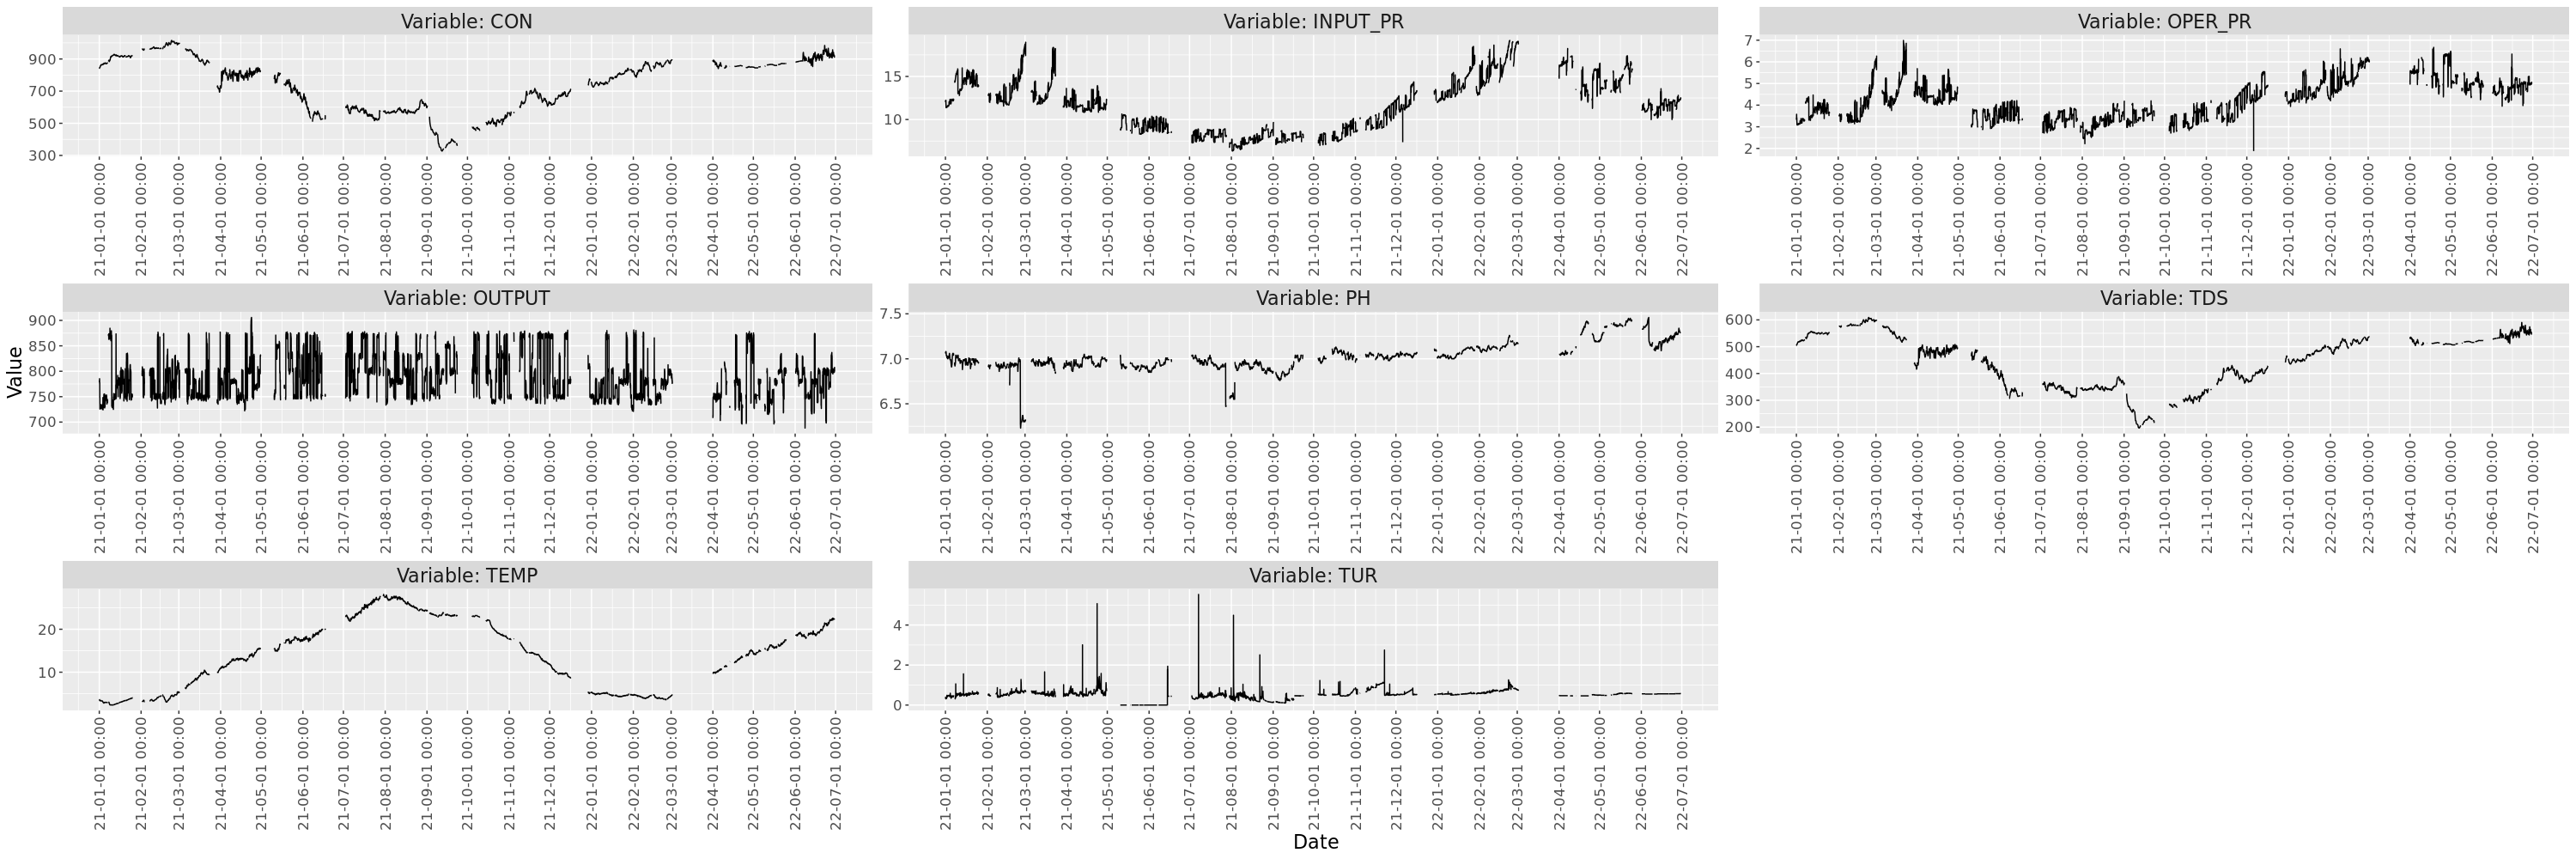

In [16]:
# 독립변수 시계열 그래프
options(repr.plot.width = 30, repr.plot.height = 10)
ts_graph_fn(input_df = as.data.frame(data_df[, -3]), input.var = 'DATE', input.scales = 'free')

(RO막, MF막)역세척, 화학세정 부분과 한 변수라도 NA가 있으면 모든 변수를 NA처리했기 때문에 중간중간 값이 비어있는 것을 확인할 수 있습니다.  

## 컬럼선택

원수 수질로 막 운영인자를 예측하므로 수질 관련 컬럼이 아닌 'OPER_PR'(운영차압), 'OUTPUT'(생산량), 'INPUT_PR'(유입압력)을 삭제합니다.  
또한 데이터 탐색에서 본 바와 같이 모델의 복잡성을 줄이기 위해 'TDS'(원수 TDS)를 삭제합니다.

In [17]:
# 컬럼선택 

# 원수수질 데이터 아니면 제외(시간에 따라 변하지 않음)
# select(열이름): 데이터에서 열 선택
data_df <- data_df %>% select(-c('OPER_PR', 'TDS', 'INPUT_PR', 'OUTPUT'))

In [18]:
# 데이터 구조 확인

# str(): 데이터 구조, 변수 개수, 변수명, 데이터 유형, 관측치 미리보는 함수
str(data_df)

tibble [13,104 × 6] (S3: tbl_df/tbl/data.frame)
 $ DATE : POSIXct[1:13104], format: "2021-01-01 00:00:01" "2021-01-01 01:00:01" ...
 $ SFLUX: num [1:13104] 5.9 5.84 5.83 5.89 5.9 ...
 $ TEMP : num [1:13104] 3.69 3.68 3.61 3.59 3.52 3.48 3.44 3.41 3.39 3.38 ...
 $ TUR  : num [1:13104] 0.41 0.39 0.38 0.33 0.32 0.32 0.34 0.34 0.34 0.31 ...
 $ CON  : num [1:13104] 840 840 841 843 844 ...
 $ PH   : num [1:13104] 7.06 7.06 7.07 7.07 7.07 7.07 7.08 7.08 7.08 7.08 ...


## 데이터 분할

전체 데이터를 모델 학습에 쓰일 데이터(train dataset)와 모델 평가에 쓰일 데이터(test dataset)로 분할합니다.

In [19]:
# train/test 분할
# round(숫자, 자리): 숫자를 지정한 자리에서 반올림시킴 
# nrow(data): data의 행의 수 출력
train.index <- round(nrow(data_df) * 0.8)  # 8:2 소수첫째자리에서 반올림
train_df <- data_df[c(1:train.index), ]
test_df <- data_df[-c(1:train.index), ]

In [20]:
# 확인
# cat(내용): 내용을 출력해서 보여줌 
cat('train의 행의 수', nrow(train_df), '\n')
cat('test의 행의 수', nrow(test_df))

train의 행의 수 10483 
test의 행의 수 2621

## 데이터 스케일링

In [21]:
# 데이터 스케일링
# 표준화(Standardization)

# 스케일된 데이터 담을 변수 생성
# data.frame(): 데아터프레임 생성
# matrix(nrow): 행의수가 nrow인 행렬 생성
# mean(): 평균 계산
# sd(): 표준편차 계산

# DATE 항목과 Y 변수를 제외하고 데이터 스케일링
train_x_df <- train_df[, !(names(train_df) %in% c('DATE', y.var))]
test_x_df <- test_df[, !(names(test_df) %in% c('DATE', y.var))]

# train_df의 컬럼명
col.names <- names(train_x_df)

# 데이터 스케일링
for (i in (1:length(col.names))){
    col.mean <- mean(pull(train_x_df, col.names[i]), na.rm = TRUE)
    col.sd <- sd(pull(train_x_df, col.names[i]), na.rm = TRUE)
    
    train_x_df[, col.names[i]] <- (train_x_df[, col.names[i]] - col.mean) / col.sd  # 표준화
    test_x_df [, col.names[i]] <- (test_x_df[, col.names[i]] - col.mean) / col.sd
}

# DATE 항목과 Y 변수 합치기
scaled_train_df <- cbind(train_df[, (names(train_df) %in% c('DATE', y.var))], train_x_df)
scaled_test_df <- cbind(test_df[, (names(test_df) %in% c('DATE', y.var))], test_x_df)

In [22]:
# 결과 확인하기
summary(scaled_train_df)
summary(scaled_test_df)

      DATE                         SFLUX            TEMP        
 Min.   :2021-01-01 00:00:01   Min.   :3.260   Min.   :-1.3542  
 1st Qu.:2021-04-20 04:30:01   1st Qu.:4.513   1st Qu.:-1.0720  
 Median :2021-08-07 09:00:01   Median :4.799   Median :-0.0699  
 Mean   :2021-08-07 09:00:01   Mean   :4.765   Mean   : 0.0000  
 3rd Qu.:2021-11-24 13:30:01   3rd Qu.:5.025   3rd Qu.: 1.0324  
 Max.   :2022-03-13 18:00:01   Max.   :7.335   Max.   : 1.7524  
                               NA's   :2795    NA's   :2795     
      TUR               CON                PH         
 Min.   :-1.9072   Min.   :-2.3525   Min.   :-6.1517  
 1st Qu.:-0.2891   1st Qu.:-0.8573   1st Qu.:-0.3545  
 Median : 0.0962   Median : 0.0681   Median : 0.0596  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.4045   3rd Qu.: 0.8349   3rd Qu.: 0.5565  
 Max.   :19.3988   Max.   : 1.8211   Max.   : 2.3785  
 NA's   :2795      NA's   :2795      NA's   :2795     

      DATE                         SFLUX            TEMP        
 Min.   :2022-03-13 19:00:01   Min.   :2.462   Min.   :-0.4678  
 1st Qu.:2022-04-10 02:00:01   1st Qu.:3.119   1st Qu.: 0.0712  
 Median :2022-05-07 09:00:01   Median :3.377   Median : 0.3185  
 Mean   :2022-05-07 09:00:01   Mean   :3.383   Mean   : 0.3385  
 3rd Qu.:2022-06-03 16:00:01   3rd Qu.:3.689   3rd Qu.: 0.6501  
 Max.   :2022-06-30 23:00:01   Max.   :4.146   Max.   : 1.0855  
                               NA's   :1007    NA's   :1007     
      TUR               CON               PH        
 Min.   :-0.1349   Min.   :0.7595   Min.   :0.5565  
 1st Qu.:-0.0194   1st Qu.:0.8518   1st Qu.:1.7159  
 Median : 0.2118   Median :0.9385   Median :2.4613  
 Mean   : 0.1333   Mean   :1.0015   Mean   :2.3653  
 3rd Qu.: 0.2503   3rd Qu.:1.1381   3rd Qu.:3.2894  
 Max.   : 0.4045   Max.   :1.6315   Max.   :4.0348  
 NA's   :1007      NA's   :1007     NA's   :1007    

## 시점 지연

24시간 전의 원수 수질(독립변수)로 현재의 막의 운영인자(종속변수)를 예측합니다.  
독립변수만 24시간 시점을 lag시켜 데이터를 만들어줍니다.

<img src = 'image/lag.png' alt = 'Drawing' style = 'width: 500px;'/>

In [23]:
# time lag 수행

# make_lag_data_fn(): 데이터 시점을 이동시키는 사용자 함수
lag <- 24
train_lag_df <- make_lag_data_fn(data = scaled_train_df[, -1], y = y.var, times = lag) 
test_lag_df <- make_lag_data_fn(data = scaled_test_df[, -1], y = y.var, times = lag) 

# y변수에 맞게 DATE변수 설정
train_date_col <- as.data.frame(scaled_train_df[24+1:nrow(scaled_train_df)-24, 'DATE'])
test_date_col <- as.data.frame(scaled_test_df[24+1:nrow(scaled_test_df)-24, 'DATE'])

names(train_date_col) <- c('DATE')
names(test_date_col) <- c('DATE')

train_lag_df <- cbind(train_date_col, train_lag_df)
test_lag_df <- cbind(test_date_col, test_lag_df)

# 결측치 행 제거
train_lag_df <- na.omit(train_lag_df)
test_lag_df <- na.omit(test_lag_df)

In [24]:
# 컬럼이름 변경
if (y.var == 'SFLUX'){  # RO막
    names(train_lag_df) <-c('DATE', 'SFLUX', 'TEMP', 'TUR', 'CON', 'PH')
    names(test_lag_df) <-c('DATE', 'SFLUX', 'TEMP', 'TUR', 'CON', 'PH')
        } else {  # MF막
    names(train_lag_df) <-c('DATE', 'R', 'TEMP', 'TUR', 'CON', 'PH')
    names(test_lag_df) <-c('DATE', 'R', 'TEMP', 'TUR', 'CON', 'PH')
}

# 차원 확인
dim(train_lag_df)
dim(test_lag_df)

[1] 6965    6

[1] 1404    6

## x,y분할

train_lag_df데이터를 예측에 쓰일 독립변수(x)와 예측 대상인 종속변수(y)로 분할 합니다.

In [25]:
# x,y분할
# as.matrix(): 행렬로 변환
x_train <- as.matrix(train_lag_df %>% select(-y.var, -DATE))
y_train <- as.matrix(train_lag_df %>% select(y.var))
x_test <- as.matrix(test_lag_df %>% select(-y.var, -DATE))
y_test <-as.matrix(test_lag_df %>% select(y.var))

In [26]:
# 데이터 차원 확인
cat(' x_train 차원:', dim(x_train), '\n', 'y_train 차원:', dim(y_train), '\n')
cat(' x_test 차원:', dim(x_test), '\n', 'y_test 차원:', dim(y_test))

 x_train 차원: 6965 4 
 y_train 차원: 6965 1 
 x_test 차원: 1404 4 
 y_test 차원: 1404 1

## 데이터 재구성(reshape)

In [27]:
# array로 변형    

# array(data, dim): 데이터를 차원(dim)에 맞춰서 array로 생성
feature <- dim(x_train)[2]
train_x_arr <- array(data = as.numeric(unlist(x_train)),  # array로 lstm에 넣을 dimension맞춰주기
                     dim = c(nrow(x_train), 1, feature))                  
train_y_arr <- array(data = y_train, dim = c(length(y_train), 1))  
test_x_arr <- array(data = as.numeric(unlist(x_test)),  
                     dim = c(nrow(x_test), 1, feature))     
test_y_arr <- array(data = y_test, dim = c(length(y_test), 1)) 

In [28]:
# 데이터 차원 확인
cat(' train_x_arr 차원:', dim(train_x_arr), '\n', 'train_y_arr 차원:', dim(train_y_arr), '\n')
cat(' test_x_arr 차원:', dim(test_x_arr), '\n', 'test_y_arr 차원:', dim(test_y_arr ))

 train_x_arr 차원: 6965 1 4 
 train_y_arr 차원: 6965 1 
 test_x_arr 차원: 1404 1 4 
 test_y_arr 차원: 1404 1

차원이 6965 1 4 이면  6965은 행의 수, 1은 timestep, 6은 feature수를 의미합니다.

# 모델 학습

## LSTM 
**[LSTM(Long Short Term Memory)]**
* 인공신경망 중 RNN의 장기 의존성 문제를 해결하기 위해 개발된 모형으로, 장기 의존성 문제를 해결하기 위해 3개의 게이트(Gate)를 모형에 도입함.
* RNN의 장기 의존성 문제: RNN이 학습이 진행되면서 RNN의 은닉층의 이전의 정보가 마지막까지 전달되지 못하는 현상
* 여기서 게이트는 은닉층 안에서의 구조를 의미하며, 3개의 게이트는 망각 게이트(각각 직전시점의 은닉층의 값을 얼마나 수용할지 결정), 입력 게이트(현 시점의 입력층의 값을 얼마나 수용할지 결정), 출력 게이트(출력의 여부를 결정)로 구성됨.
* 게이트를 통해 이전 시점의 중요한 정보만을 선택적으로 사용할 수 있으며, 먼 시점의 중요한 정보도 현 시점의 정보에 영향을 미칠 수 있게 하기에 장기 의존성 문제를 해결할 수 있음.
* 게이트마다 연산이 필요하므로 학습에 매우 오랜 시간이 걸린다는 단점이 존재함.

LSTM 모델을 학습시키기 위해서는 입력 데이터의 차원(dimension)을 설정해야 합니다.  
> 첫 번째 차원: 배치(batch)의 크기  
두 번째 차원: 입력 데이터의 시간 축(time step)  
세 번째 차원: 입력 데이터의 특징(feature)

예를 들어, 하루의 기온과 습도 데이터를 입력으로 사용한다면, 각 데이터는 두 개의 특징(기온과 습도)으로 구성되며, 하루에 대한 데이터는 24개(24시간)가 됩니다.  
이 경우 LSTM 모델의 time step은 24, 특징은 2가 됩니다. 

또한, LSTM 모델에서는 입력 데이터를 batch로 처리하기 때문에, 입력 데이터의 차원에는 batch size 차원도 추가됩니다. 보통 32, 64, 128 등의 값을 사용합니다.   
따라서 LSTM 모델의 입력 데이터의 최종 차원은 (batch_size, time_step, feature)이 됩니다.


* 배치(batch) : batch 크기는 모델 학습 중 파라미터(parameter)를 업데이트할 때 사용할 데이터 개수를 의미합니다.batch 크기만큼 데이터를 활용해 모델이 예측한 값과 실제 정답 간의 오차(손실함수 이용)를 계산하여 최적화알고리즘(optimizer)이 파라미터(parameter)를 업데이트합니다.
* 파라미터(parameter): 모델 내부에서 결정되는 변수이며, 어떤 시스템이나 함수의 특정한 성질을 나타냅니다. 매개변수라고도 합니다.


* 모델 생성 후 train dataset으로 학습하고, 모델이 잘 학습되었는지 확인하기 위해 train dataset으로 예측하여 실제값과 비교합니다.

<span style = 'background:#ffd33d'> 미리 학습된 모델을 사용하지 않고 직접 모델학습을 하려면 아래의 셀의 주석을 풀고 실행하세요 </span>

In [29]:
#####################
# lstm 모델 정의
#####################
# keras_model_sequential():케라스 모델 생성
# layer_lstm(): lstm 레이어 생성 (return_sequences: 시퀀스 출력 여부, LSTM 레이어를 여러개로 쌓아올릴 때는 True)
# stateful: 현재 학습된 상태가 다음 학습 시 초기 상태로 전달
# layer_dropout():과적합을 방지하기 위해 학습에서 무작위로 뉴런을 제거하는 레이어
# time_distributed():각 스텝마다 cost(오류)를 계산해서 하위 스텝으로 오류를 전파하여 각 가중치(weight)를 업데이트
# compile(): 모델을 기계가 이해할 수 있도록 변환
# loss:손실함수 , optimizer:최적화함수 , metrics:평가척도
# summary(): 모델 정보 출력

# model_lstm <- keras_model_sequential()
# model_lstm %>% layer_lstm(units = 32, # size of the layer
#                           batch_input_shape = c(1, 1, 4), # batch size, timesteps, features
#                           return_sequences = TRUE,
#                           stateful = TRUE) %>%
#              layer_dropout(rate = 0.5)%>%
#              layer_lstm(units = 32,
#                           return_sequences = TRUE,
#                           stateful = TRUE) %>%
#             layer_dropout(rate = 0.5) %>%
#             time_distributed(keras::layer_dense(units = 1))

#################
# 모델 컴파일
#################
# model_lstm %>%
#   compile(loss = 'mae', optimizer = 'adam', metrics = 'RootMeanSquaredError')

##################
# 모델 학습
##################
# fit(): 만들었던 모델의 파라미터를 튜닝

# lstm_history <- model_lstm %>% fit(x = train_x_arr,
#                                   y = train_y_arr,
#                                   batch_size = 1,
#                                   epochs = 30,
#                                   verbose = 1,
#                                   validation_split = 0.2,
#                                   shuffle = FALSE)

#################
# 모델 저장
#################
# if (y.var == 'SFLUX'){  # RO막
#     save_model_hdf5(model_lstm, 'output/RO_model_lstm.h5')  # model저장
#     saveRDS(lstm_history, 'output/RO_lstm_history.rds')  # history저장
#     } else {  # MF막
#     save_model_hdf5(model_lstm, 'output/MF_model_lstm.h5')
#     saveRDS(lstm_history, 'output/MF_lstm_history.rds')
# }

In [30]:
# 학습된 모델 불러오기

# 모델 생성, 학습에 많은 시간이 소요되므로 미리 저장된 학습이 완료된 모델을 불러와서 모델 예측부터 진행 
# load_model_hdf5(): 저장된 케라스 모델 불러오기
if (y.var == 'SFLUX'){  # RO막
    model_lstm <- load_model_hdf5('output/RO_model_lstm.h5')
    lstm_history <- readRDS('output/RO_lstm_history.rds')
    } else {  # MF막
    model_lstm <- load_model_hdf5('output/MF_model_lstm.h5')
    lstm_history <- readRDS('output/MF_lstm_history.rds')
}

Loaded Tensorflow version 2.9.3



In [31]:
# 모델 정보
summary(model_lstm)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_1 (LSTM)                      (1, 1, 32)                      4736        
 dropout_1 (Dropout)                (1, 1, 32)                      0           
 lstm (LSTM)                        (1, 1, 32)                      8320        
 dropout (Dropout)                  (1, 1, 32)                      0           
 time_distributed (TimeDistributed)  (1, 1, 1)                      33          
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
________________________________________________________________________________


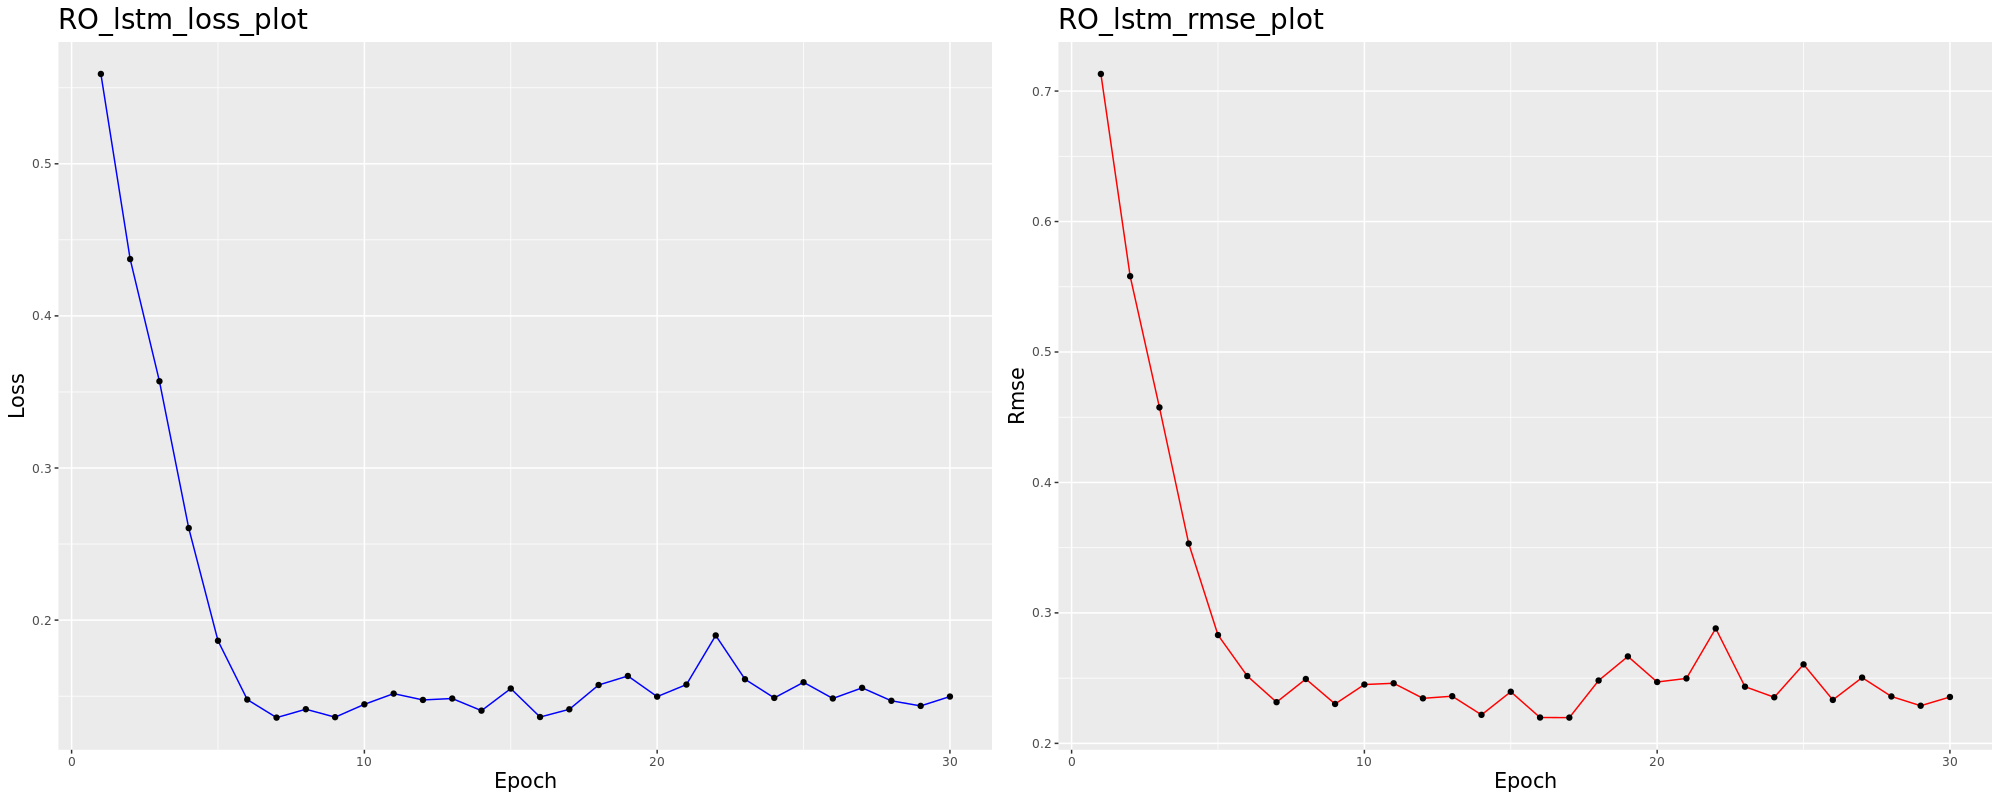

In [32]:
# loss와 rmse확인

# train_plot_fn(): lstm, gru의 loss, rmse확인, nn 시각화하는 사용자 함수
train_plot_fn(y = y.var, model = 'lstm', history = lstm_history)

Epoch 6까지는 loss와 rmse가 감소하는 경향을 보입니다. 이후에는 비슷한 loss와 rmse를 보여줍니다.

In [33]:
# 모델 예측

# predict(): 모델로 종속변수를 예측
pred_lstm_result <- model_lstm %>%
                        predict(train_x_arr, batch_size = 1) %>%
                        .[, , 1]  

In [34]:
# 스케일을 원래 상태로 복원

# restore_scale_fn(): 변경된 스케일을 원래 스케일로 복원시키는 사용자 함수
lstm_train_result_df <- restore_scale_fn(train_df = train_df, y = y.var, actual = train_y_arr, predictions = pred_lstm_result)
head(lstm_train_result_df, 2)

,actual,predicted
,<dbl>,<dbl>
1,7.404820,6.919728
2,7.397256,6.916672


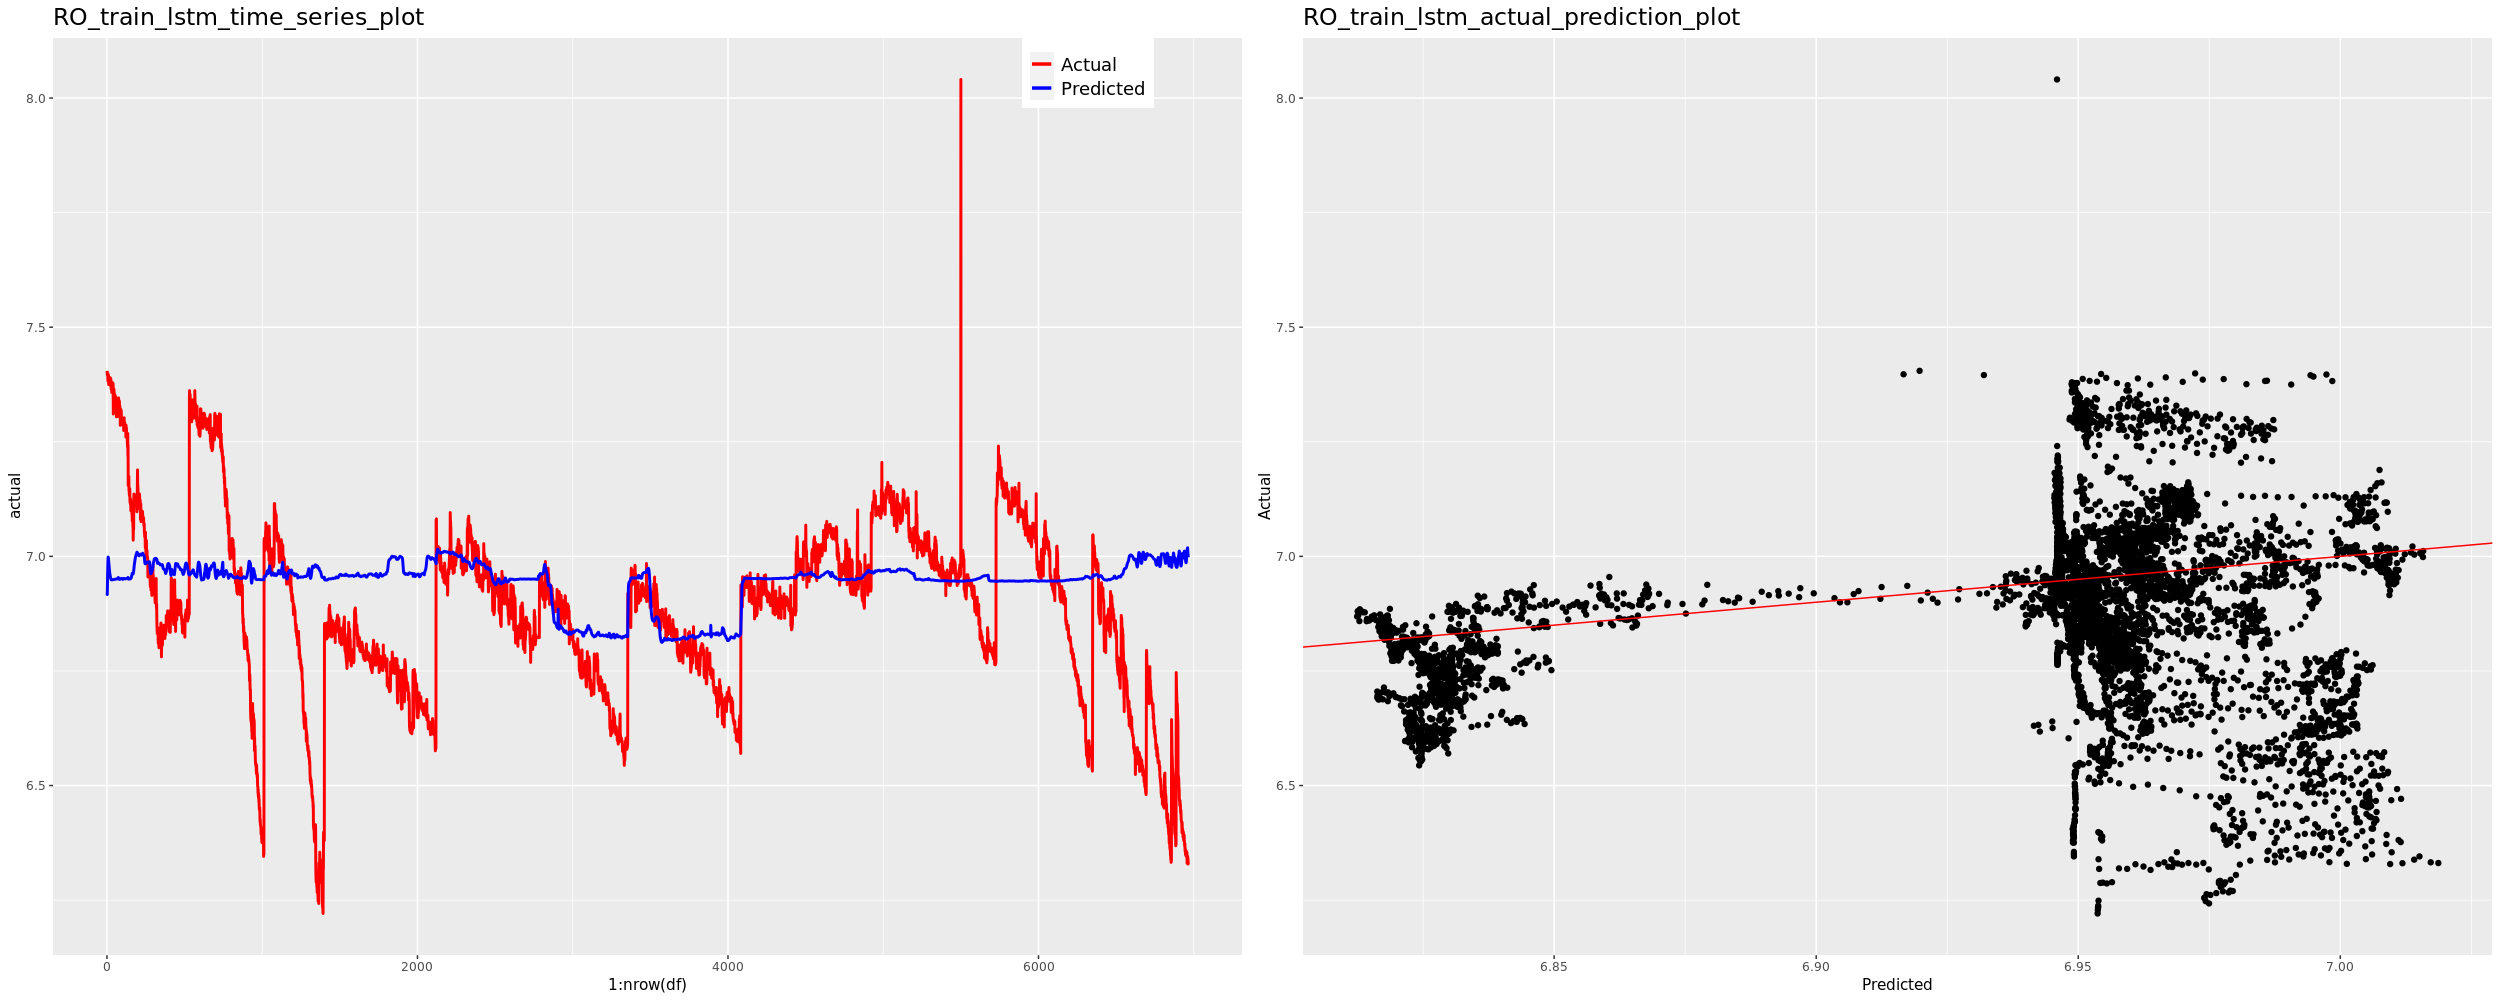

In [35]:
# plot 생성

# result_plot_fn(): 시계열 plot, 실제값, 예측값 비교 plot 생성, 저장하는 사용자 함수
result_plot_fn(y = y.var, df = lstm_train_result_df, div = 'train_lstm')

왼쪽의 plot은 실제값과 예측값을 시계열plot으로 시각화한 것입니다. 빨간선이 실제값, 파란선이 예측값입니다.  
빨간선과 파란선의 평균은 비슷해보이지만, 추세를 따라가지 못하는것이 확인됩니다. 

오른쪽의 plot은 실제값과 예측값을 산점도로 나타낸 것입니다. x축이 실제값, y축이 예측값입니다.  
빨간선은 y=x선이며, 이 선에 가까우면 예측이 잘 된 데이터 지점입니다.(실제값과 예측값의 차이가 적으므로)  

**[모델 평가 지표]**  
모델의 종속변수가 연속형 변수일 때 평가지표로 활용되는 MAE, RMSE 를 활용하여 모델 평가(0에 가까울수록 예측력 높음)

* MAE(Mean absolute error): 모델의 예측값과 실제값의 차이의 절대값의 평균으로 가장 직관적으로 해석에 용이함.   
$MAE =  {1\over N}(\sum_{i}^{N}{|x_i- y_i|})$ 

* RMSE(Root mean square error): 예측값과 실제값의 차이의 면적의 합에 루트를 한 지표로 특이치에 강하고 가장 보편적으로 사용됨.  
$RMSE =  \sqrt{{1\over N}(\sum_{i}^{N}{(x_i- y_i)^2})}$ 

In [36]:
# 평가지표
evaluation_fn(y = y.var, df = lstm_train_result_df, div = 'train_lstm')

rmse:  0.2038298 
mae:  0.1443391

## GRU
**[GRU(Gated Recurrent Unit)]**

* GRU는 LSTM의 장기 의존성 문제에 대한 해결책을 유지하면서, 은닉 상태를 업데이트하는 계산을 줄였음.
* 그래서 GRU는 성능은 LSTM과 유사하면서 복잡했던 LSTM의 구조를 간단화한 모델임.
* LSTM의 경우 forget gate(망각 게이트), input gate(입력 게이트), output gate(출력 게이트) 3개의 gate가 있었지만, GRU에서는 reset gate(과거의 정보를 일정부분 리셋하는 게이트), update gate(이전의 정보를 얼마나 유지시킬지 결정하는 게이트) 2개의 gate만을 사용함. 
* 또한 cell state(이전 시점의 cell state를 다음 시점으로 넘겨줌), hidden state(은닉상태)가 합쳐져 하나의 hidden state로 표현함.

* 모델 생성 후 train dataset으로 학습하고, 모델이 잘 학습되었는지 확인하기 위해 train dataset으로 예측하여 실제값과 비교합니다.

<span style = 'background:#ffd33d'> 미리 학습된 모델을 사용하지 않고 직접 모델학습을 하려면 아래의 셀의 주석을 풀고 실행하세요 </span>

In [37]:
#####################
# gru 모델 정의
#####################
# bidirectional(): 양방향 레이어 생성 (batch_input_shape: 배치를 추가한 입력층 차원)
# layer_gru(): gru레이어 생성 (units: 뉴런의 수)
# layer_dense(): 레이어 추가 (activation: 활성화 함수)

# model_gru <- keras_model_sequential() %>% 
#   bidirectional(
#     layer_gru(units = 32), 
#       batch_input_shape = c(1, 1, 4)
#   ) %>%
#   layer_dense(units = 32, activation = 'relu')
#   layer_dense(units = 1)

#################
# 모델 컴파일
#################
# model_gru %>% compile(
#   loss = 'mae',
#   optimizer = optimizer_rmsprop(),
#   metrics = 'RootMeanSquaredError',
# )

##################
# 모델 학습
##################
# gru_history <- model_gru %>% fit(x = train_x_arr,
#                                  y = train_y_arr,
#                                  steps_per_epoch = 500,
#                                  epochs = 30,
#                                  validation_split = 0.2
# )

#################
# 모델 저장
#################
# if (y.var == 'SFLUX'){  # RO막
#     save_model_hdf5(model_gru, 'output/RO_model_lstm.h5')  # model저장
#     saveRDS(gru_history, 'output/RO_lstm_history.rds')  # history저장
#     } else {  # MF막
#     save_model_hdf5(model_gru, 'output/MF_model_lstm.h5')
#     saveRDS(gru_history, 'output/MF_lstm_history.rds')
# }

In [38]:
# 학습된 모델 불러오기

# 모델 생성, 학습에 많은 시간이 소요되므로 미리 저장된 학습이 완료된 모델을 불러와서 모델예측부터 진행
if (y.var == 'SFLUX'){  # RO막
    model_gru <- load_model_hdf5('output/RO_model_gru.h5')
    gru_history <- readRDS('output/RO_gru_history.rds')
    } else {  # MF막
    model_gru <- load_model_hdf5('output/MF_model_gru.h5')
    gru_history <- readRDS('output/MF_gru_history.rds')
}

In [39]:
# 모델 정보
summary(model_gru)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 bidirectional_1 (Bidirectional)    (1, 64)                         7296        
 dense_3 (Dense)                    (1, 32)                         2080        
Total params: 9,376
Trainable params: 9,376
Non-trainable params: 0
________________________________________________________________________________


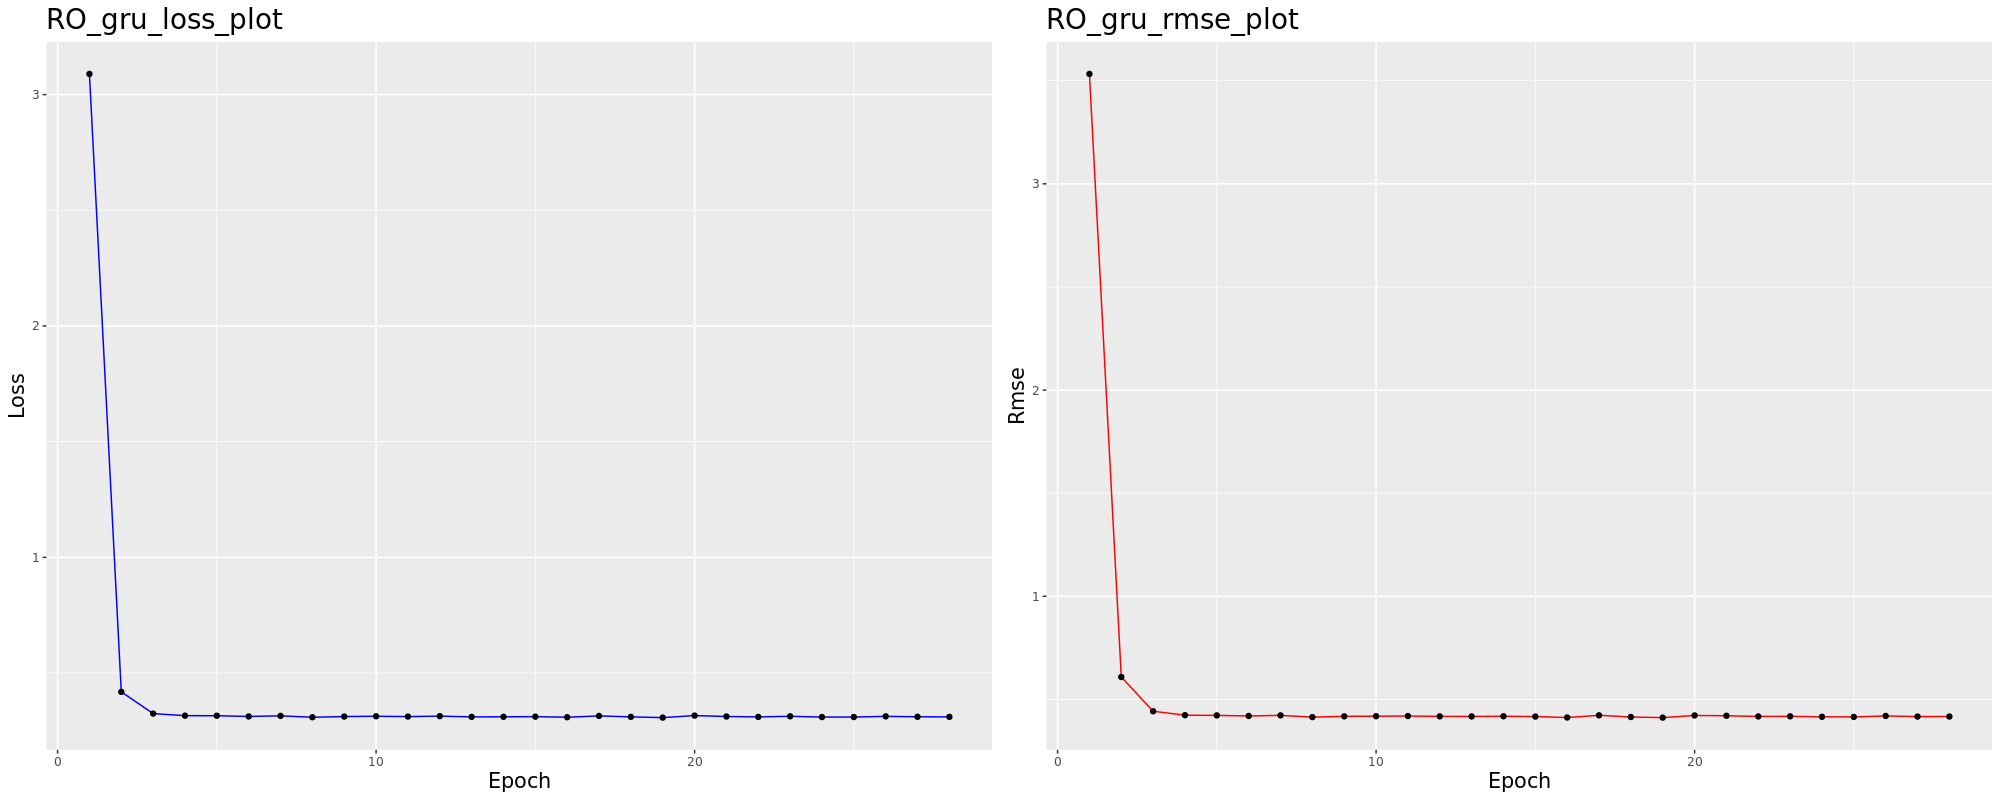

In [40]:
# loss와 rmse확인
train_plot_fn(y = y.var, model = 'gru', history = gru_history)

In [41]:
# 모델 예측
pred_gru_result <- model_gru %>%
                        predict(train_x_arr, batch_size = 1) %>%
                         .[, 1] 

In [42]:
# 스케일을 원래 상태로 복원
gru_train_result_df  <- restore_scale_fn(train_df = train_df, y = y.var, actual = train_y_arr, predictions = pred_gru_result)
head(gru_train_result_df, 2)

,actual,predicted
,<dbl>,<dbl>
1,7.404820,6.931331
2,7.397256,6.931763


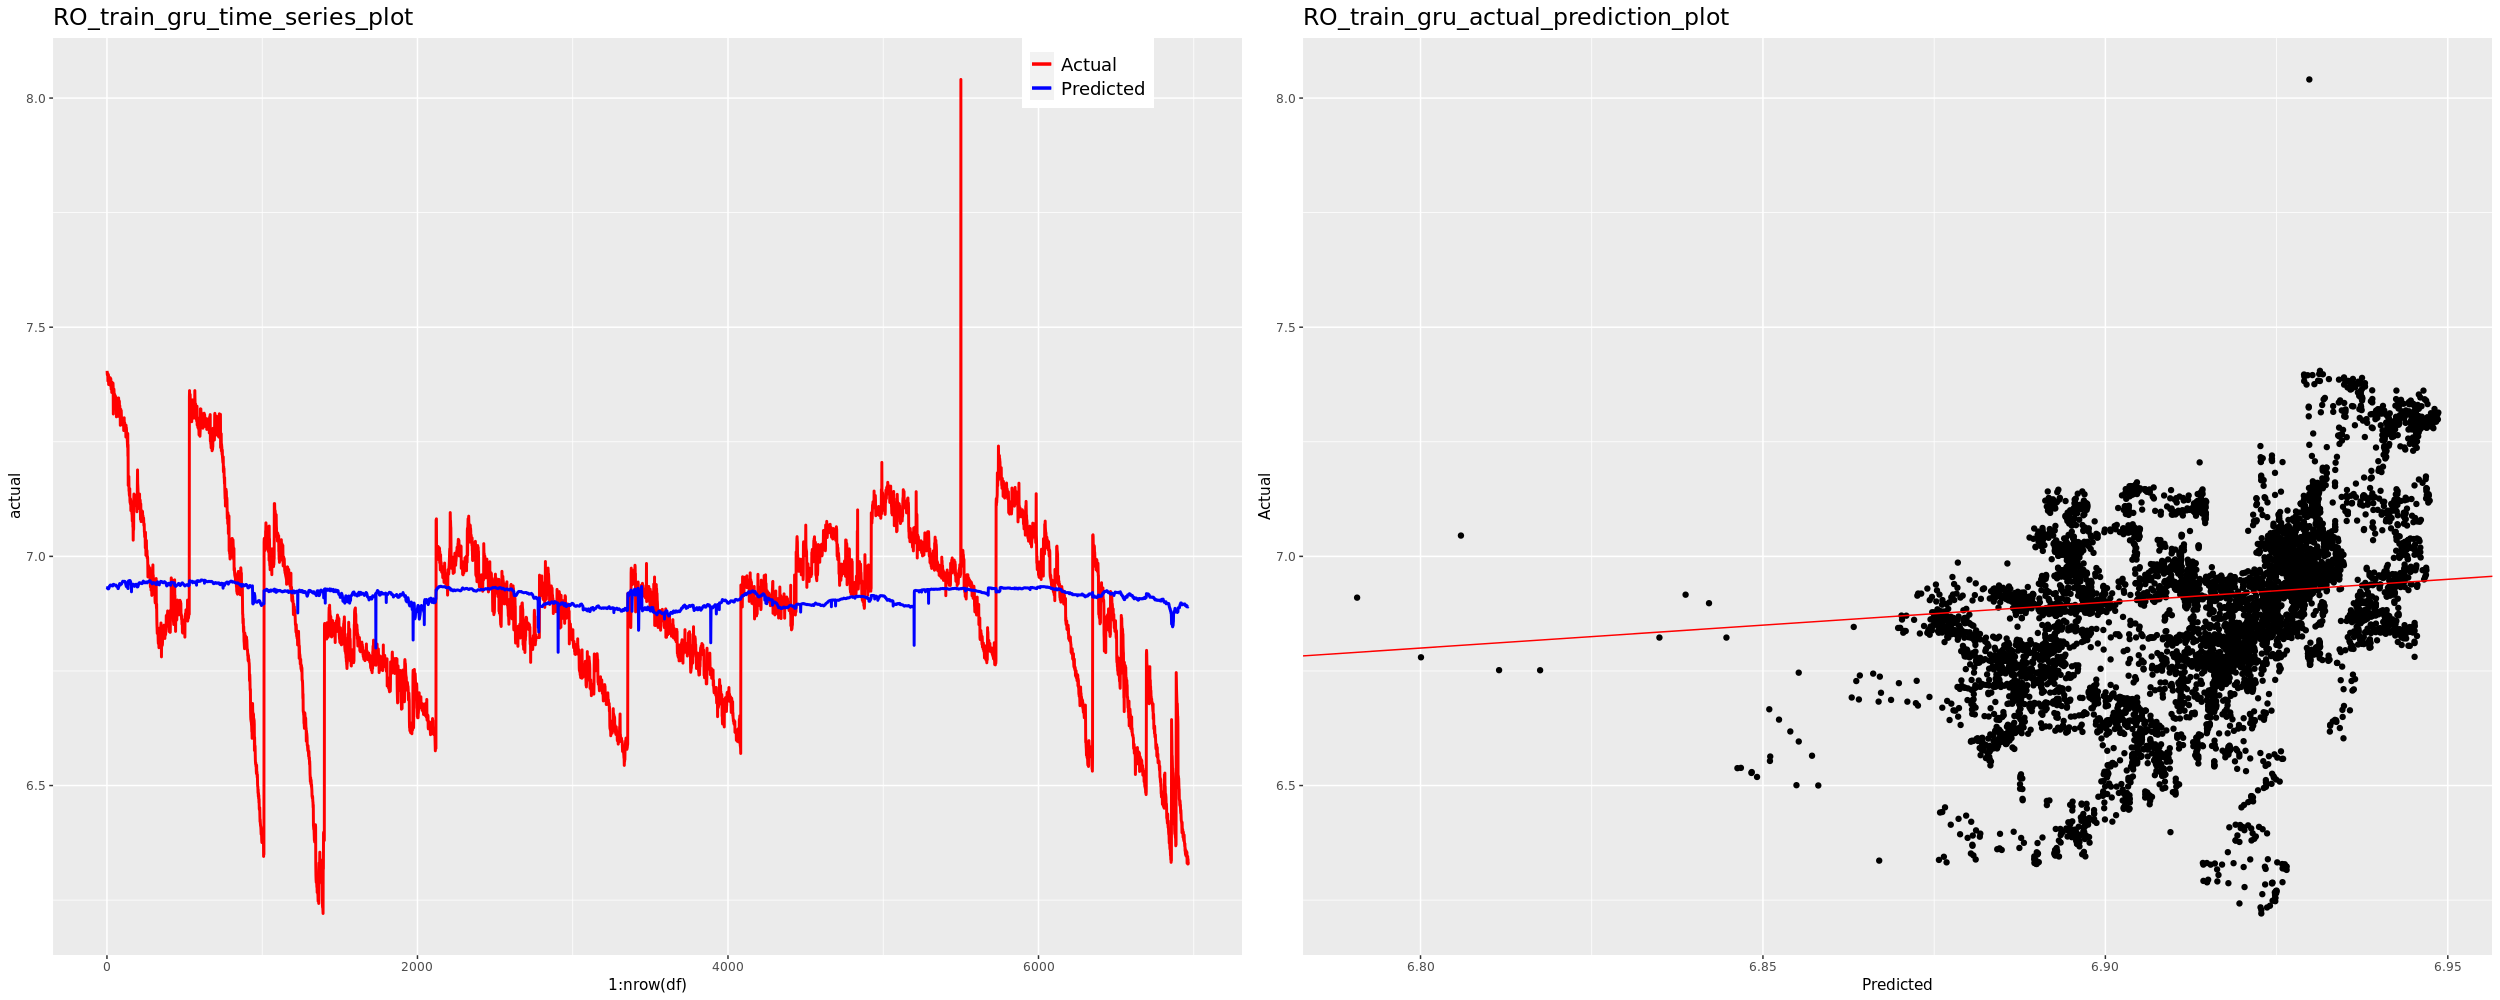

In [43]:
# plot 생성
result_plot_fn(y = y.var, df = gru_train_result_df, div = 'train_gru')

In [44]:
# 평가지표 생성
evaluation_fn(y = y.var, df = gru_train_result_df, div = 'train_gru')

rmse:  0.1917261 
mae:  0.1433923

## NN
**[NN(Neural Network)]**
- 사람의 신경망 원리와 구조를 모방하여 만든 기계학습 알고리즘
- 신경망은 다수의 입력 데이터를 받는 입력층(Input), 데이터의 출력을 담당하는 출력층(Output), 입력층과 출력층 사이에 존재하는 레이어들(은닉층)로 이루어짐.
- 은닉층이 2개 이상이면 DNN(Deep Neural Network)이라고도 함.
- 인공신경망은 시냅스의 결합으로 네트워크를 형성한 인공뉴런(노드)이 학습을 통해 시냅스의 결합 세기를 변화시켜, 문제 해결 능력을 가지는 모델임.
- 은닉층이 많으면 학습하는데에 정확도가 올라가지만 그만큼 연산량이 기하 급수적으로 늘어나게 됨.

* 모델 생성 후 train dataset으로 학습하고, 모델이 잘 학습되었는지 확인하기 위해 train dataset으로 예측하여 실제값과 비교합니다.

<span style = 'background:#ffd33d'> 미리 학습된 모델을 사용하지 않고 직접 모델학습을 하려면 아래의 셀의 주석을 풀고 실행하세요 </span>

In [45]:
##################
# 모델 학습
##################
# hidden: 각 층에서 은닉층과 은닉뉴런의 수를 지정하는 벡터, c(5)는 은닉층이 1개이며 은닉노드가 5개인 신경망을 뜻함.
# algorithm = 'rprop+': 알고리즘 타입, rprop+은 탄력적 역전파를 의미
# 역전파는 입력 데이터를 전방향으로 전파하고, 예측 값과 실제 값 사이의 오차를 계산한 후, 이 오차를 역방향으로 전파하여 가중치와 편향을 업데이트
# 탄력적 역전파는 역전파 방법 중 하나이며, 학습률(learning rate)을 유동적으로 조정하여 오차 최소화가 목표
# err.fct: loss function 지정, logistic함수
# act.fct: activation function지정, sse(sum of squared errors)
# linear.output: 논리값을 뜻하는 것으로 activation function을 사용하지 않는다면 TRUE로 입력
# threshold: 학습 중단 기준, 에러 함수의 편미분(partial derivatives)을 위한 임계값을 지정하는 숫자. 기본값: 0.01.
# stepmax: 신경망에서 훈련 시킬 최대 단계

# 모형식 설정
# x.var <- c('TEMP', 'TUR', 'CON', 'PH')
# formula.x <- as.formula(paste(y.var, '~', paste(x.var, collapse = ' + ')))

# model_nn <- neuralnet(formula.x, data = train_lag_df, hidden = c(5), algorithm = 'rprop+', 
#     err.fct = 'sse', act.fct = 'logistic', threshold = 0.1, stepmax = 1e6, linear.output = TRUE)

#################
# 모델 저장
#################
# if (y.var == 'SFLUX'){  # RO막
#     saveRDS(lstm_history, 'output/RO_model_nn.h5')  
#     } else {  # MF막
#     saveRDS(lstm_history, 'output/MF_model_nn.h5')
# }

In [46]:
# 학습된 모델 불러오기

# 모델 생성, 학습에 많은 시간이 소요되므로 미리 저장된 학습이 완료된 모델을 불러와서 모델예측부터 진행합니다. 
if (y.var == 'SFLUX'){  # RO막
    model_nn <- readRDS('output/RO_model_nn.h5')
    } else {  # MF막
    model_nn <- readRDS('output/MF_model_nn.h5')
}

In [47]:
# 모델 정보
summary(model_nn)

                    Length Class      Mode    
call                   10  -none-     call    
response             6965  -none-     numeric 
covariate           27860  -none-     numeric 
model.list              2  -none-     list    
err.fct                 1  -none-     function
act.fct                 1  -none-     function
linear.output           1  -none-     logical 
data                    6  data.frame list    
exclude                 0  -none-     NULL    
net.result              1  -none-     list    
weights                 1  -none-     list    
generalized.weights     1  -none-     list    
startweights            1  -none-     list    
result.matrix          34  -none-     numeric 

png 
  2

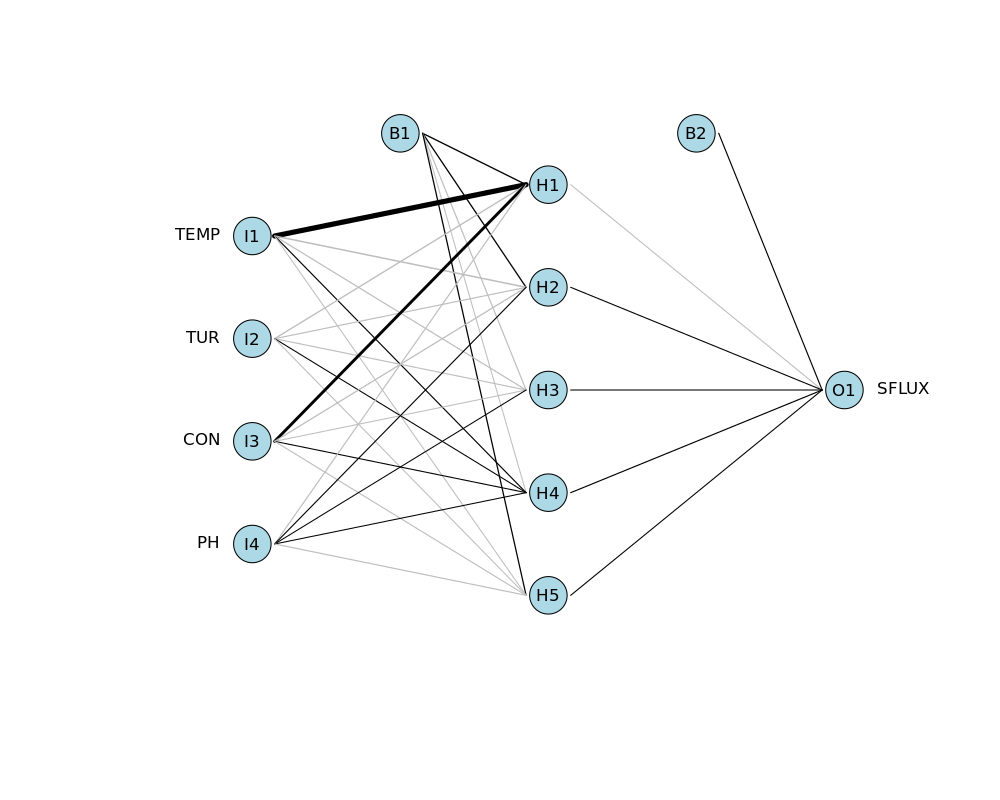

In [48]:
# 신경망 확인
suppressPackageStartupMessages({
train_plot_fn(y = y.var, model = 'nn', history = model_nn)
    })

위 plot은 신경망을 시각화 한것입니다. 입력층, 은닉층, 출력층 구조를 확인할 수 있습니다.

In [49]:
# 모델 예측
pred_nn_result <- model_nn %>%
                        predict(train_lag_df, batch_size = 1) 

In [50]:
# 스케일을 원래 상태로 복원
nn_train_result_df  <- restore_scale_fn(train_df = train_df, y = y.var, actual = train_y_arr, predictions = pred_nn_result)
head(nn_train_result_df, 2)

,actual,predicted
,<dbl>,<dbl>
1,7.404820,7.170278
2,7.397256,7.189094


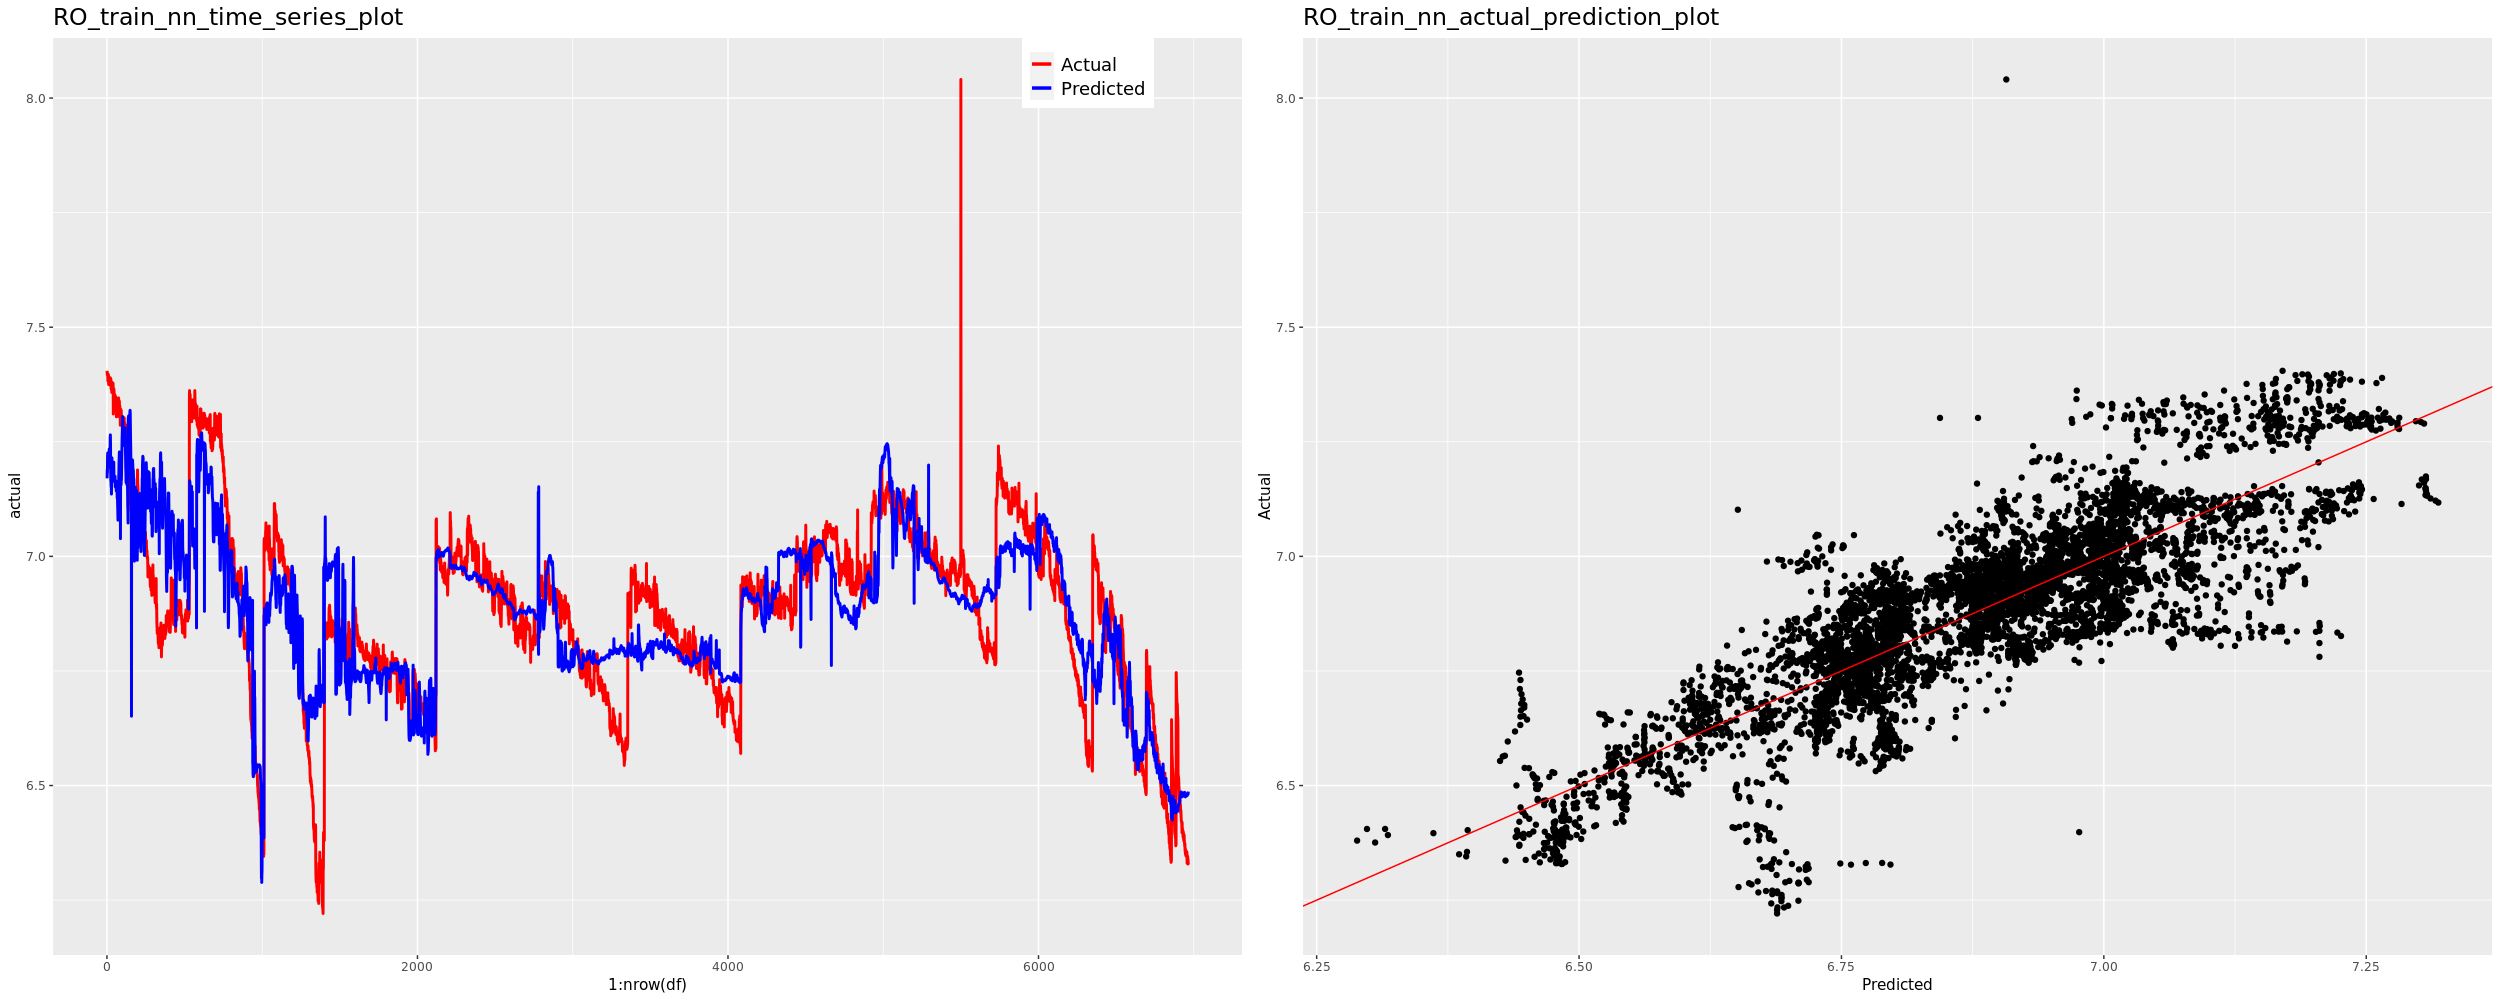

In [51]:
# plot 생성
result_plot_fn(y = y.var, df = nn_train_result_df, div = 'train_nn')

In [52]:
# 평가지표
evaluation_fn(y = y.var, df = nn_train_result_df, div = 'train_nn')

rmse:  0.1074452 
mae:  0.08011621

# 모델 평가

## LSTM
* 학습된 모델을 이용해 test dataset을 예측합니다. 이후 예측값과 실제값(test dataset)를 비교합니다.

In [53]:
# 모델 예측
pred_lstm_test_result <- model_lstm %>%
                        predict(test_x_arr, batch_size = 1) %>%
                        .[, , 1]  

In [54]:
# 스케일을 원래 상태로 복원
lstm_test_result_df  <- restore_scale_fn(train_df = train_df, y = y.var, actual = test_y_arr, predictions = pred_lstm_test_result)
head(lstm_test_result_df, 2)

,actual,predicted
,<dbl>,<dbl>
1,6.235973,6.994854
2,6.222320,6.992999


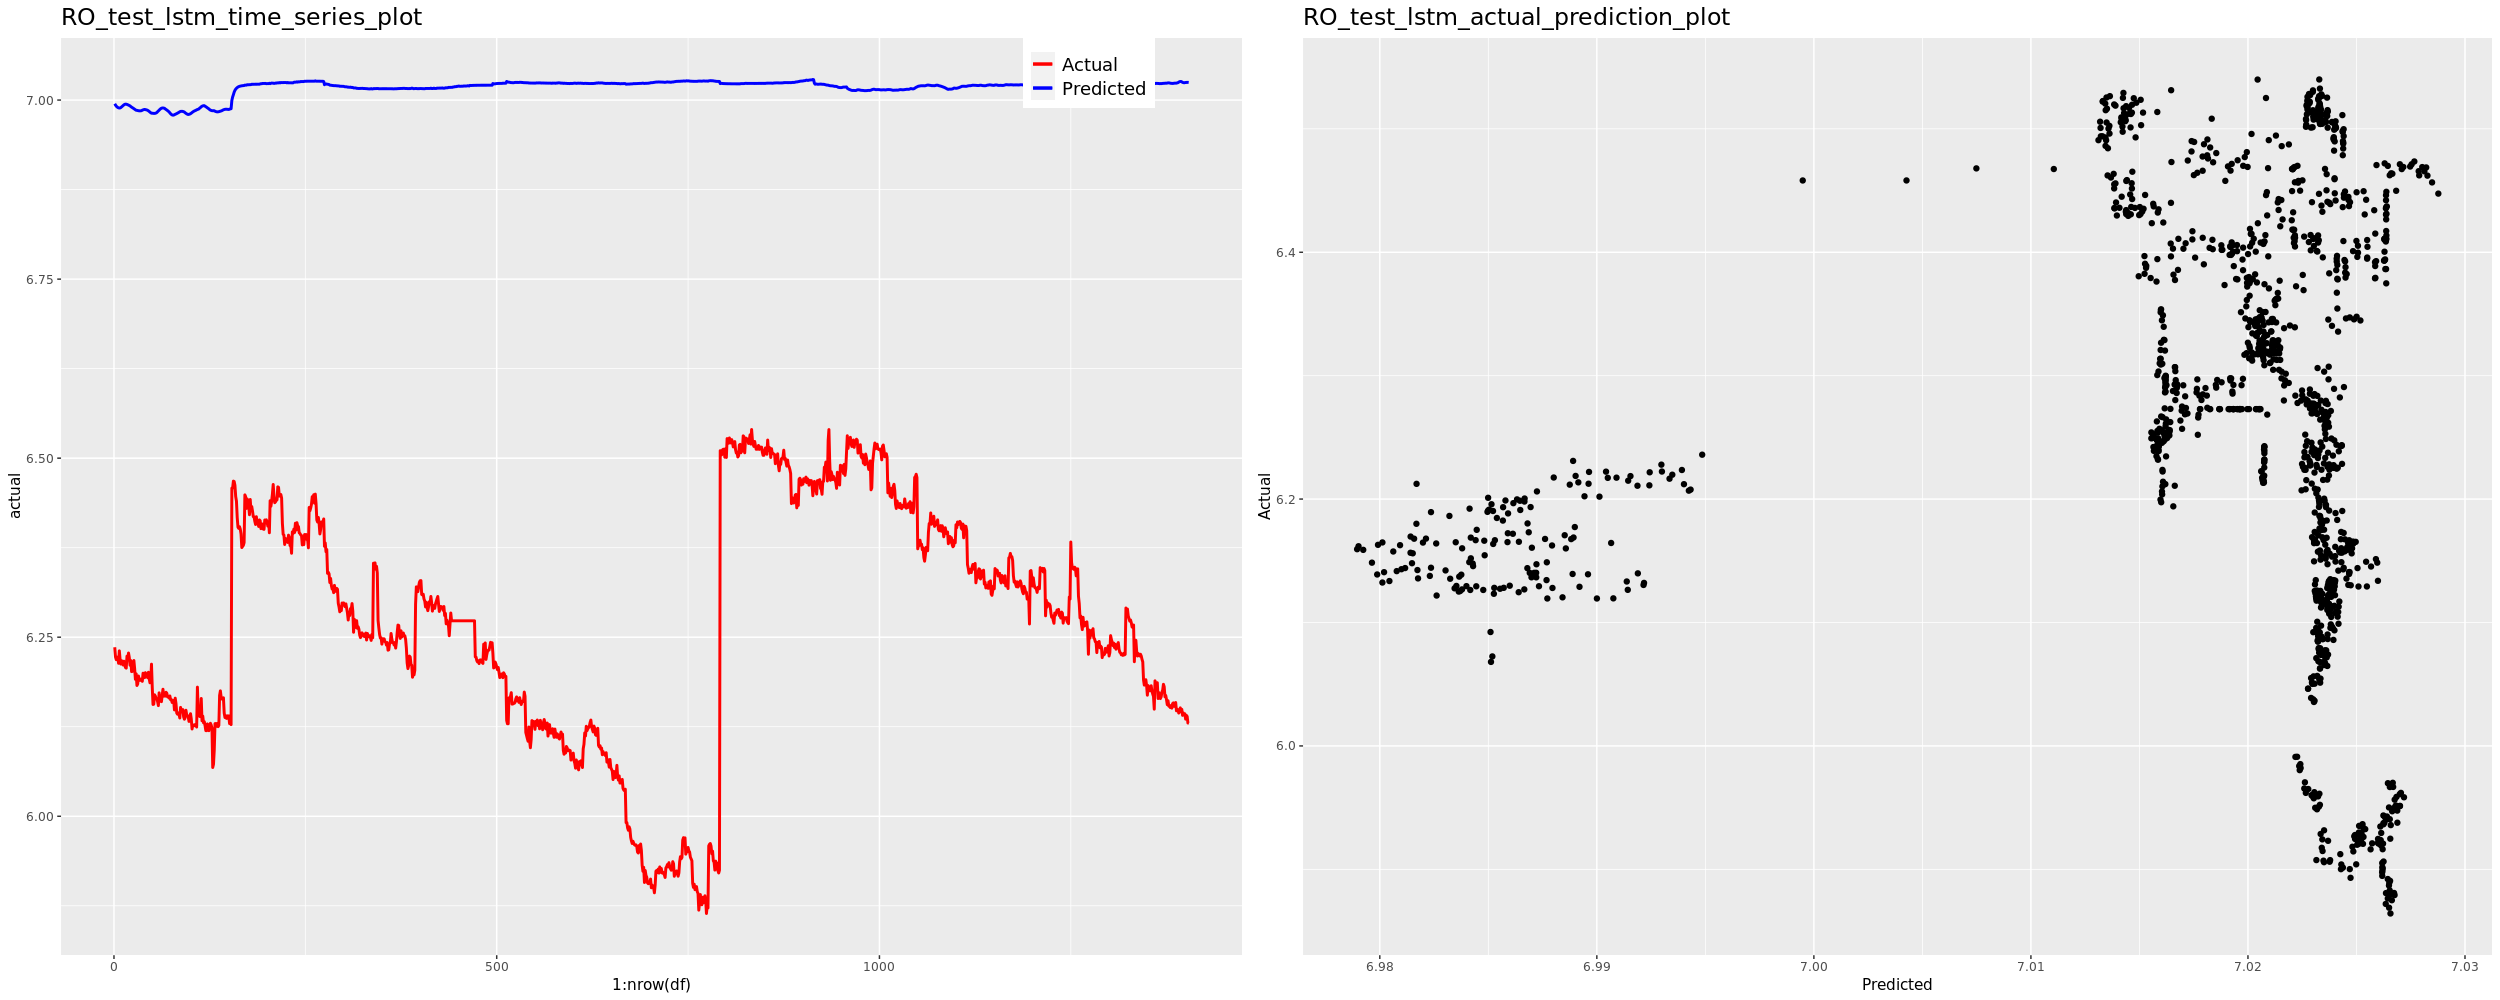

In [55]:
# plot 생성
result_plot_fn(y = y.var, df = lstm_test_result_df, div = 'test_lstm')

In [56]:
# 평가지표
evaluation_fn(y = y.var, df = lstm_test_result_df, div = 'test_lstm')

rmse:  0.7677507 
mae:  0.7498902

## GRU
* 학습된 모델을 이용해 test dataset을 예측합니다. 이후 예측값과 실제값(test dataset)를 비교합니다.

In [57]:
# 모델 예측
gru_test_predict <- model_gru %>%
                        predict(test_x_arr, batch_size = 1) %>%
                         .[, 1]

In [58]:
# 스케일을 원래 상태로 복원
gru_test_result_df  <- restore_scale_fn(train_df = train_df, y = y.var, actual = test_y_arr, predictions  = gru_test_predict)
head(gru_test_result_df, 2)

,actual,predicted
,<dbl>,<dbl>
1,6.235973,6.920718
2,6.222320,6.920955


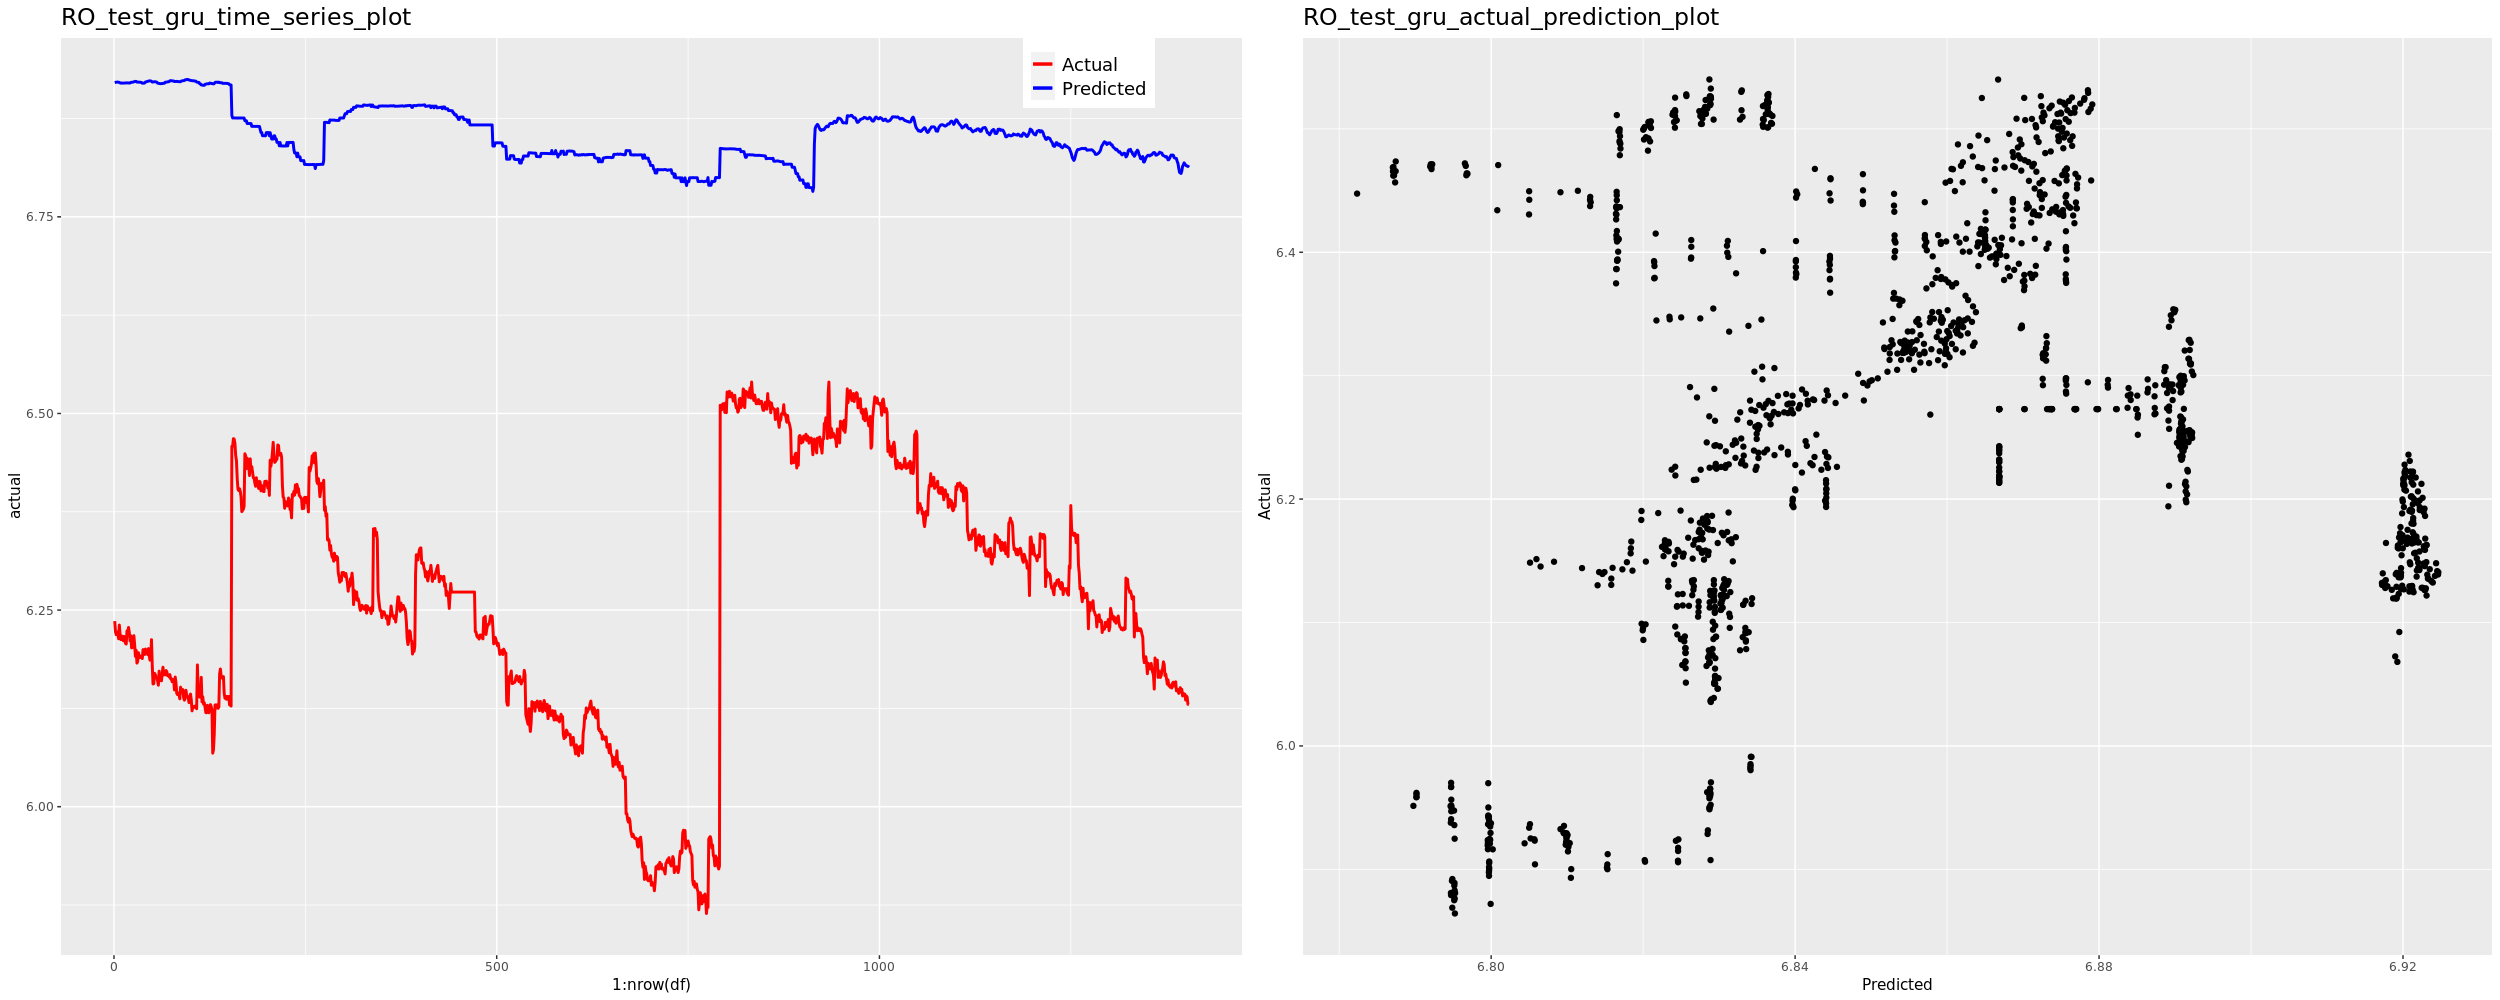

In [59]:
# plot 생성
result_plot_fn(y = y.var, df = gru_test_result_df, div = 'test_gru')

In [60]:
# 평가지표
evaluation_fn(y = y.var, df = gru_test_result_df, div = 'test_gru')

rmse:  0.6093251 
mae:  0.587078

## NN
* 학습된 모델을 이용해 test 데이터를 예측합니다. 이후 예측값과 실제값(test 데이터)를 비교합니다.

In [61]:
# 모델 예측
pred_nn_test_result <- model_nn %>%
                        predict(test_lag_df, batch_size = 1) 

In [62]:
# 스케일을 원래 상태로 복원
nn_test_result_df <- restore_scale_fn(train_df = train_df, y = y.var, actual = test_y_arr, predictions = pred_nn_test_result)
head(nn_test_result_df, 2)

,actual,predicted
,<dbl>,<dbl>
1,6.235973,6.559737
2,6.222320,6.561579


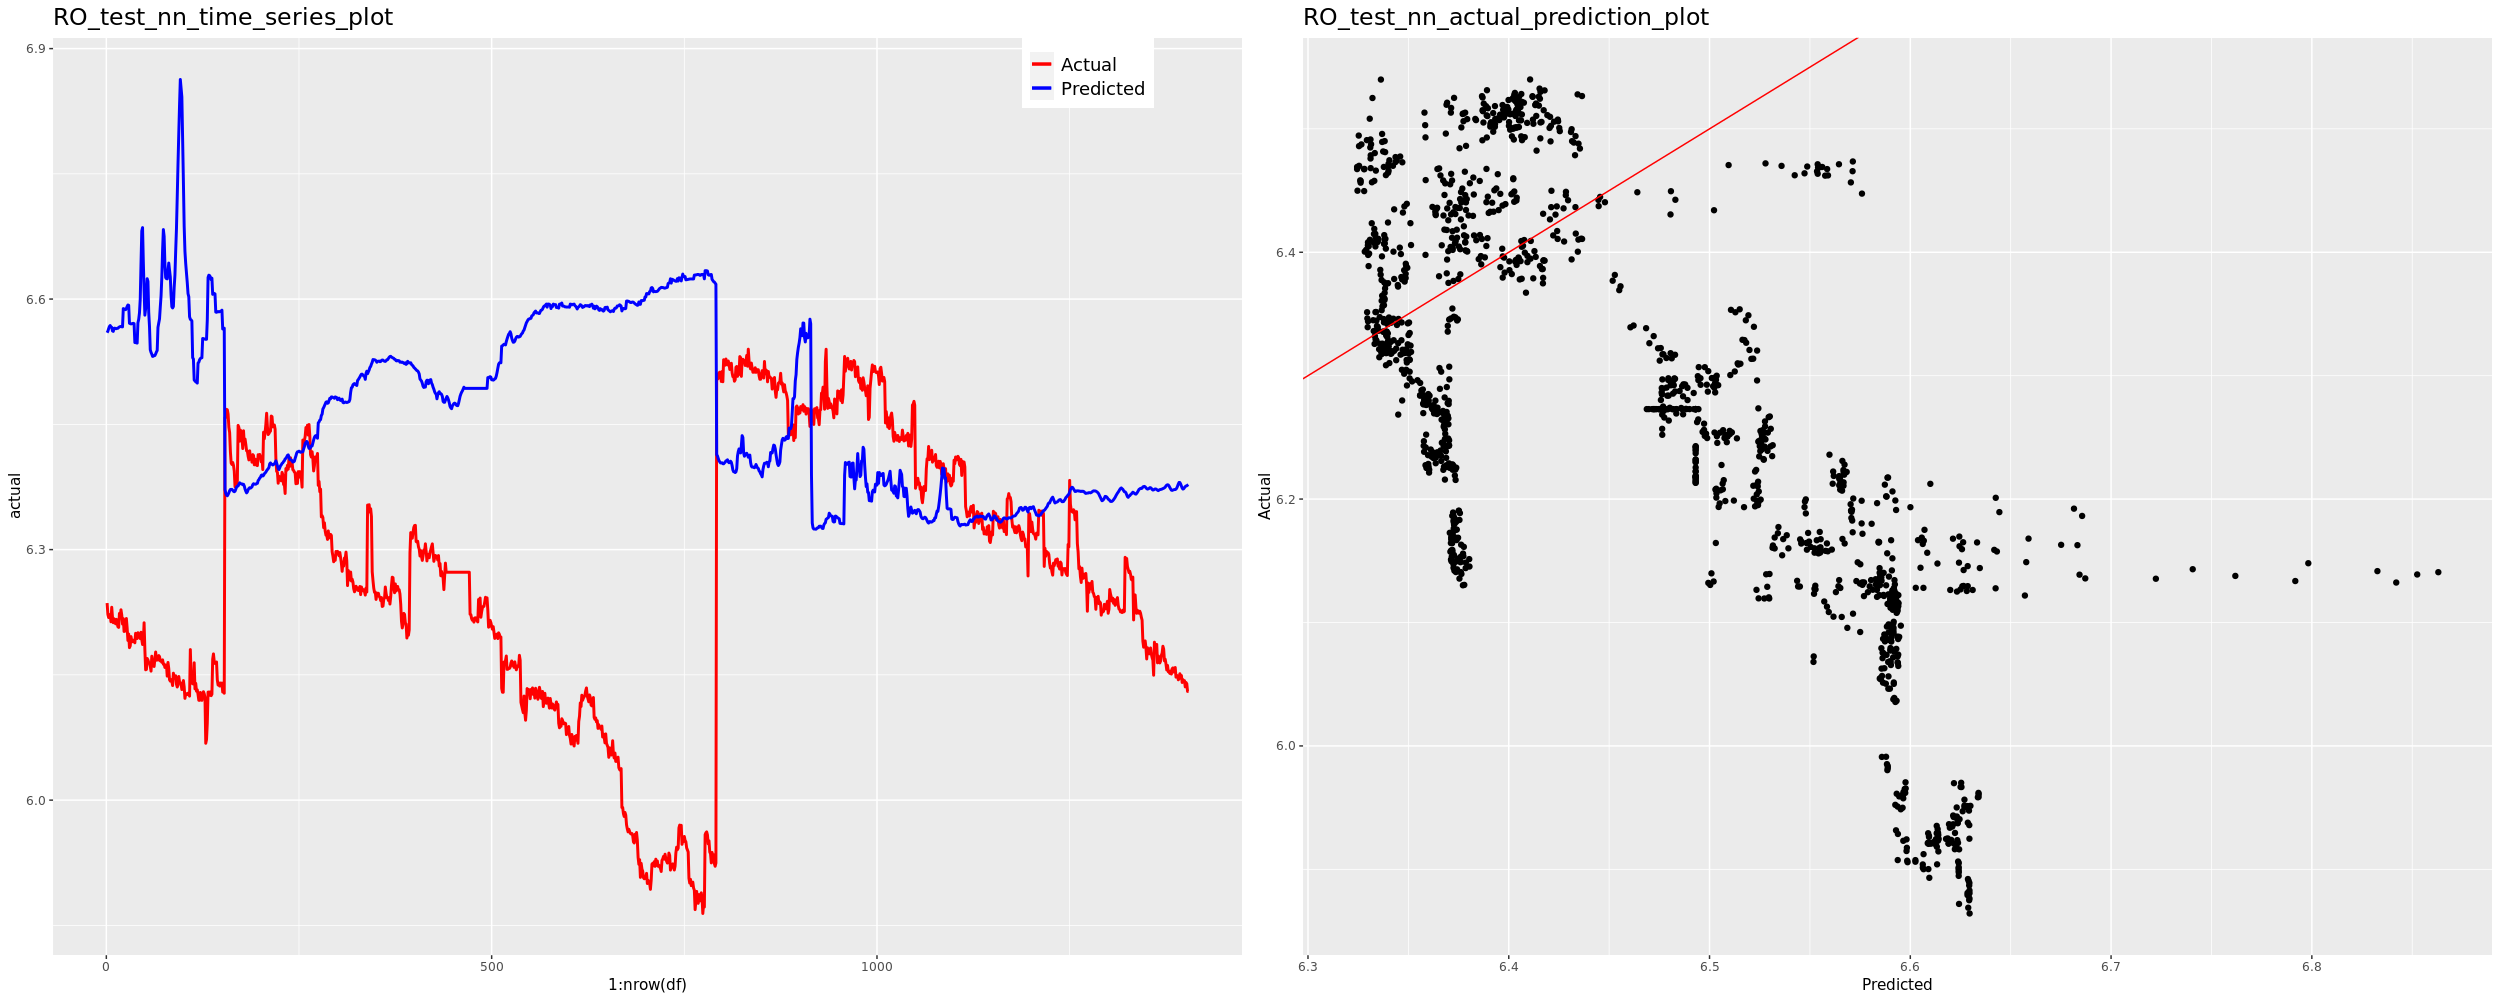

In [63]:
# plot 생성
result_plot_fn(y = y.var, df = nn_test_result_df, div = 'test_nn')

In [64]:
# 평가지표
evaluation_fn(y = y.var, df = nn_test_result_df, div = 'test_nn')

rmse:  0.3201747 
mae:  0.2428118

# 학습포인트

* 24시간 시점을 지연시킨 데이터 생성 등 모델학습을 위한 데이터 재구성  
* 막 상태를 모니터링 하기 위해 원수 수질데이터를 활용한 막 운영인자 값 예측
* LSTM, GRU 등 예측 모델 적용 후, 시계열 데이터에 적합한 최적 모델링 선정

# 레시피 정보

* 디지털 물산업 분야 학습용 예제 레시피 제작
* 생성일자: 2023년 05월 31일
* 사용언어: R
* Kwater 빅데이터콘테스트 발표연도 및 부서: 2022년/서산권지사